In [5]:
library(DBI)

con <- dbConnect(
  bigrquery::bigquery(),
  project = 'hawkfish-prod-0c4ce6d0',
  dataset = 'tactical_ads_data'
  )

In [6]:
query = "

DECLARE TODAY DATE DEFAULT DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY);

CREATE TEMP TABLE z_scores AS 

WITH
group_cat AS (
SELECT DISTINCT clean_name, clean_campaign, ad_type, ad_objective,
REGEXP_CONTAINS(ad_name, 'O2P') as O2P,
REGEXP_CONTAINS(ad_name, 'Exp') as exp,
REGEXP_CONTAINS(ad_name, 'LB') as lb,
objective
FROM `hawkfish-prod-0c4ce6d0.tactical_ads_data.facebook_view_cache`),

group_metric AS (
SELECT DISTINCT clean_name, clean_campaign, O2P, lb, ad_type, objective,
CASE
    WHEN ad_objective = 'Persuasion' THEN 'Per'
    WHEN ad_objective = 'List building' THEN 'DR'
    WHEN lb IS TRUE THEN 'DR'
    WHEN O2P IS TRUE AND ad_type = 'Video' THEN 'Per'
    WHEN O2P IS TRUE AND ad_type <> 'Video' THEN 'Per'
    WHEN ad_type = 'Video' THEN 'Per'
    WHEN ad_type = 'StaticLink' THEN 'DR'
    WHEN objective = 'EVENT_RESPONSES' THEN 'DR'
    ELSE 'Missing'
END AS actual_objective,
CASE
    WHEN lb IS TRUE THEN 'conversions'
    WHEN O2P IS TRUE AND ad_type = 'Video' THEN 'ten_seconds_views'
    WHEN O2P IS TRUE AND ad_type <> 'Video' THEN 'one_day_view_thru'
    WHEN ad_type = 'Video' THEN 'clicks'
    WHEN ad_type = 'StaticLink' THEN 'clicks'
    WHEN objective = 'EVENT_RESPONSES' THEN 'rsvp'
    ELSE 'Missing'
END AS dr_metric,
CASE
    WHEN lb IS TRUE AND ad_type = 'Video' THEN 'one_day_view_thru + ten_seconds_views'
    WHEN lb IS TRUE AND ad_type <> 'Video' THEN 'one_day_view_thru'
    WHEN O2P IS TRUE AND ad_type = 'Video' THEN 'one_day_view_thru + ten_seconds_views'
    WHEN O2P IS TRUE AND ad_type <> 'Video' THEN 'one_day_view_thru'
    WHEN ad_type = 'Video' THEN 'one_day_view_thru + ten_seconds_views'
    WHEN ad_type = 'StaticLink' THEN 'one_day_view_thru'
    WHEN objective = 'EVENT_RESPONSES' THEN 'one_day_view_thru + ten_seconds_views'
    ELSE 'Missing'
END AS bl_metric,
FROM group_cat
),

ad_metric_state AS (
SELECT clean_name, objective, actual_objective, state, dr_metric, bl_metric, 
CASE 
  WHEN dr_metric = 'conversions' THEN SUM(conversions)/SUM(impressions)
  WHEN dr_metric = 'ten_seconds_views' THEN SUM(ten_seconds_views)/SUM(impressions)
  WHEN dr_metric = 'one_day_view_thru' THEN SUM(one_day_view_thru)/SUM(impressions)
  WHEN dr_metric = 'clicks' THEN SUM(clicks)/SUM(impressions)
  WHEN dr_metric = 'rsvp' THEN SUM(rsvp)/SUM(impressions)
END AS dr_value, 
SUM(one_day_view_thru)/SUM(impressions) AS bl_value_1, 
CASE 
  WHEN bl_metric = 'one_day_view_thru + ten_seconds_views' THEN SUM(ten_seconds_views)/SUM(impressions)
END AS bl_value_2, 
CASE 
    WHEN audience IS NOT NULL THEN audience
    ELSE 'Missing'
END AS audience,
CASE
   WHEN CAST(video_length AS INT64) = 0 THEN '0'
   WHEN CAST(video_length AS INT64) < 10 THEN '10-'
   WHEN CAST(video_length AS INT64) >=10 AND CAST(video_length AS INT64) <30 THEN '10-30'
   WHEN CAST(video_length AS INT64) >=30 THEN '30+'
END AS video_length_cat,
CAST(MAX(date_stop) AS DATE) AS latest_date,
SUM(impressions) AS impressions
FROM `hawkfish-prod-0c4ce6d0.tactical_ads_data.facebook_view_cache`
JOIN group_metric USING(clean_name, objective)
WHERE CAST(date_stop AS DATE) < TODAY
GROUP BY clean_name, objective, actual_objective, state, dr_metric, bl_metric, audience, video_length_cat
),

ad_metric AS (
SELECT clean_name, objective, actual_objective, dr_metric, bl_metric, 
CASE 
  WHEN dr_metric = 'conversions' THEN SUM(conversions)/SUM(impressions)
  WHEN dr_metric = 'ten_seconds_views' THEN SUM(ten_seconds_views)/SUM(impressions)
  WHEN dr_metric = 'one_day_view_thru' THEN SUM(one_day_view_thru)/SUM(impressions)
  WHEN dr_metric = 'clicks' THEN SUM(clicks)/SUM(impressions)
  WHEN dr_metric = 'rsvp' THEN SUM(rsvp)/SUM(impressions)
END AS dr_value, 
SUM(one_day_view_thru)/SUM(impressions) AS bl_value_1, 
CASE 
  WHEN bl_metric = 'one_day_view_thru + ten_seconds_views' THEN SUM(ten_seconds_views)/SUM(impressions)
END AS bl_value_2, 
CASE 
    WHEN audience IS NOT NULL THEN audience
    ELSE 'Missing'
END AS audience,
CASE
   WHEN CAST(video_length AS INT64) = 0 THEN '0'
   WHEN CAST(video_length AS INT64) < 10 THEN '10-'
   WHEN CAST(video_length AS INT64) >=10 AND CAST(video_length AS INT64) <30 THEN '10-30'
   WHEN CAST(video_length AS INT64) >=30 THEN '30+'
END AS video_length_cat,
CAST(MAX(date_stop) AS DATE) AS latest_date,
SUM(impressions) AS impressions
FROM `hawkfish-prod-0c4ce6d0.tactical_ads_data.facebook_view_cache`
JOIN group_metric USING(clean_name, objective)
WHERE CAST(date_stop AS DATE) < TODAY
GROUP BY clean_name, objective, actual_objective, dr_metric, bl_metric, audience, video_length_cat
),

metric_mean_std AS (
SELECT clean_campaign, O2P, lb, objective, dr_metric, bl_metric, video_length_cat,
AVG(dr_value) AS dr_value_avg, STDDEV(dr_value) AS dr_value_std,
AVG(bl_value_1) AS bl_value_1_avg, STDDEV(bl_value_1) AS bl_value_1_std,
AVG(bl_value_2) AS bl_value_2_avg, STDDEV(bl_value_2) AS bl_value_2_std,
FROM ad_metric
JOIN group_cat USING(clean_name, objective)
WHERE impressions > 200000 
AND DATE_DIFF(TODAY, latest_date, DAY) <= 31
GROUP BY clean_campaign, O2P, lb, objective, dr_metric, bl_metric, video_length_cat
HAVING COUNT(*) >= 3 AND dr_value_std > 0 AND bl_value_1_std > 0
),

rolling_impressions AS (
SELECT gm.clean_name, gm.objective, actual_objective, audience, state,
SUM(impressions) AS impressions_7days
FROM `hawkfish-prod-0c4ce6d0.tactical_ads_data.facebook_view_cache` ch
JOIN group_metric gm ON gm.clean_name=ch.clean_name
AND gm.clean_campaign=ch.clean_campaign
AND gm.ad_type=ch.ad_type
AND gm.objective=ch.objective
AND gm.O2P = REGEXP_CONTAINS(ch.ad_name, 'O2P')
AND gm.lb = REGEXP_CONTAINS(ch.ad_name, 'LB')
WHERE CAST(date_stop AS DATE) < TODAY
AND DATE_DIFF(TODAY, CAST(date_stop AS DATE), DAY) <= 8
GROUP BY clean_name, objective, actual_objective, audience, state
)

SELECT clean_name, objective, actual_objective, audience, state, dr_value, dr_value_avg, dr_value_std, bl_value_1, bl_value_1_avg, bl_value_1_std, bl_value_2, bl_value_2_avg, bl_value_2_std,
(dr_value - dr_value_avg)/dr_value_std AS z_dr,
CASE
   WHEN bl_value_2 IS NULL THEN (bl_value_1 - bl_value_1_avg)/bl_value_1_std
   ELSE 0.5*(bl_value_1 - bl_value_1_avg)/bl_value_1_std + 0.5*(bl_value_2 - bl_value_2_avg)/bl_value_2_std
END AS z_bl,
impressions_7days, latest_date,
FROM ad_metric_state
JOIN group_metric USING(clean_name, objective, actual_objective, dr_metric, bl_metric)
JOIN metric_mean_std USING(clean_campaign, O2P, lb, objective, dr_metric, bl_metric, video_length_cat)
JOIN rolling_impressions USING(clean_name, objective, audience, state, actual_objective)
WHERE DATE_DIFF(TODAY, latest_date, DAY) <= 8;

select * from z_scores;"

In [7]:
fb_scores <- dbGetQuery(con, query)

In [8]:
fb_scores$dr_z_score = (fb_scores$dr_value - fb_scores$dr_value_avg ) / fb_scores$dr_value_std
fb_scores$bl_1_z_score = (fb_scores$bl_value_1 - fb_scores$bl_value_1_avg ) / fb_scores$bl_value_1_std

In [9]:
fb_scores$dr_score <- pnorm(fb_scores$dr_z_score, 0, 1) * 100
fb_scores$bl_1_score <- pnorm(fb_scores$bl_1_z_score, 0, 1) * 100

In [10]:
head(fb_scores)

clean_name,objective,actual_objective,audience,state,dr_value,dr_value_avg,dr_value_std,bl_value_1,bl_value_1_avg,⋯,bl_value_2_avg,bl_value_2_std,z_dr,z_bl,impressions_7days,latest_date,dr_z_score,bl_1_z_score,dr_score,bl_1_score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
mikeforblackamerica_69,REACH,Per,AA,Other,0.0115637463,0.0199963223,1.861320e-02,0.0002142357,0.0004181161,⋯,0.01999632,0.01861320,-0.4530428,-0.67297918,271034,2020-02-28,-0.4530428,-0.8929155,32.52589,18.59512
honoringblackhistory_79,REACH,Per,AA,Other,0.0116522913,0.0199963223,1.861320e-02,0.0005994428,0.0004181161,⋯,0.01999632,0.01861320,-0.4482857,0.17292673,271276,2020-02-28,-0.4482857,0.7941392,32.69735,78.64428
legacyofblackwallstreet_1:20,REACH,Per,AA,Other,0.0063554135,0.0128608564,6.983320e-03,0.0006567651,0.0004182253,⋯,0.01286086,0.00698332,-0.9315688,0.11432948,72457,2020-02-22,-0.9315688,1.1602277,17.57797,87.70219
manager,REACH,Per,AL,Alabama,0.0195789450,0.0128608564,6.983320e-03,0.0002720872,0.0004182253,⋯,0.01286086,0.00698332,0.9620193,0.12561114,88207,2020-02-25,0.9620193,-0.7107970,83.19800,23.86050
getitdone,REACH,Per,AL,Alabama,0.0175079648,0.0128608564,6.983320e-03,0.0002922866,0.0004182253,⋯,0.01286086,0.00698332,0.6654583,0.02645411,205278,2020-02-26,0.6654583,-0.6125501,74.71213,27.00869
getitdone,REACH,Per,AL,Alabama,0.0002922866,0.0002989183,3.153685e-05,0.0002922866,0.0002989183,⋯,NA,NA,-0.2102853,-0.21028534,205278,2020-02-26,-0.2102853,-0.2102853,41.67225,41.67225


In [11]:
#names(fb_scores)

In [12]:
fb_scores$imp_cut <- cut(fb_scores$impressions_7days, quantile(fb_scores$impressions_7days, seq(0, 1, 0.05)), paste0("group",1:20, "max", round(quantile(fb_scores$impressions_7days,  seq(0.05, 1, 0.05))),"-"))

In [13]:
table(fb_scores$imp_cut)


       group1max6-       group2max24-       group3max56-      group4max115- 
               495                741                677                723 
     group5max200-      group6max326-      group7max494-      group8max719- 
               700                714                709                712 
    group9max1027-    group10max1469-    group11max2032-    group12max2804- 
               711                713                709                711 
   group13max3861-    group14max5385-    group15max7833-   group16max11768- 
               712                711                711                711 
  group17max19357-   group18max35319-   group19max90568- group20max4473141- 
               712                711                711                712 

In [14]:
#pnorm(2, 0, 1)

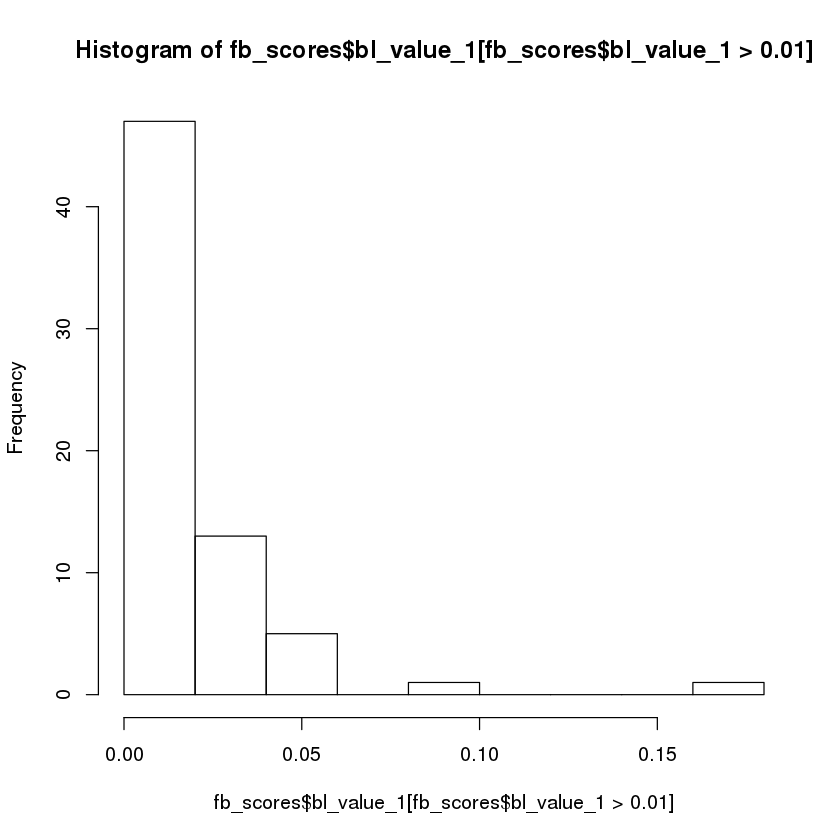

In [15]:
hist(fb_scores$bl_value_1[fb_scores$bl_value_1 > 0.01])

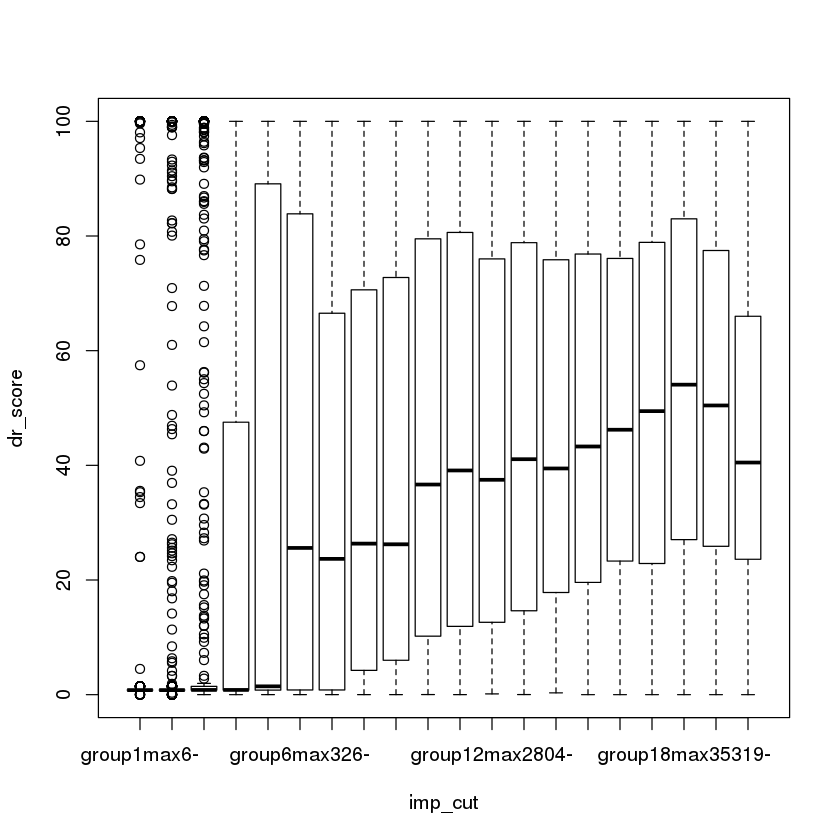

In [16]:
boxplot(dr_score ~ imp_cut, subset(fb_scores, actual_objective == 'Per'))

In [17]:
require(plyr)
score_dists <- ddply(fb_scores, .(actual_objective, imp_cut), summarize, 
     mean_dr_score =  mean(dr_score, na.rm = T),
     median_dr_score =  median(dr_score, na.rm = T),
     std_dr_score =  sd(dr_score, na.rm = T),
     mean_bl_1_score =  mean(bl_1_score, na.rm = T),
     std_bl_1_score =  sd(bl_1_score, na.rm = T),
     median_bl_1_score =  median(bl_1_score, na.rm = T)
     
     )

Loading required package: plyr



In [18]:
tail(score_dists, 50)

,actual_objective,imp_cut,mean_dr_score,median_dr_score,std_dr_score,mean_bl_1_score,std_bl_1_score,median_bl_1_score
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,DR,group1max6-,22.823600,17.2084211,8.327193,27.248438,17.18173,24.036913
2,DR,group2max24-,27.742855,17.2084211,19.486272,28.771803,20.80388,24.036913
3,DR,group3max56-,23.983609,17.2084211,14.263106,29.149341,21.75738,24.036913
4,DR,group4max115-,29.310495,22.5197624,18.620366,35.194149,28.74735,24.036913
5,DR,group5max200-,27.481083,24.1494448,14.406445,37.115217,29.38302,24.036913
6,DR,group6max326-,26.490355,23.1671772,14.295681,45.240102,30.81926,24.036913
7,DR,group7max494-,24.060826,22.4054882,8.682534,45.872991,29.38367,24.036913
8,DR,group8max719-,23.813920,22.1688373,8.938916,43.341931,27.09980,24.036913
9,DR,group9max1027-,23.824959,22.5163531,8.624613,43.245326,22.71488,36.876027


[1] 0.0006103331

[1] 0.0005873287

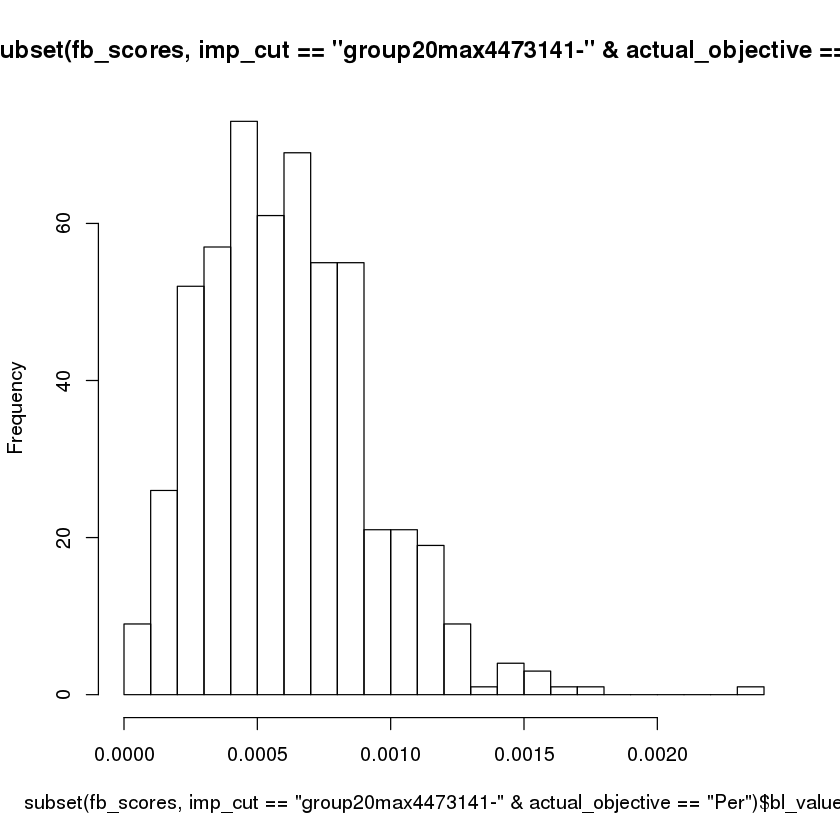

In [20]:
hist(subset(fb_scores, imp_cut == 'group20max12990522-' & actual_objective == 'Per')$bl_value_1, breaks = 20)
mean(subset(fb_scores, imp_cut == 'group20max12990522-' & actual_objective == 'Per')$bl_value_1)
median(subset(fb_scores, imp_cut == 'group20max12990522-' & actual_objective == 'Per')$bl_value_1)

In [ ]:
hist(subset(fb_scores, imp_cut == 'group20max12990522-' & actual_objective == 'Per')$dr_value, breaks = 20)
mean(subset(fb_scores, imp_cut == 'group20max12990522-' & actual_objective == 'Per')$dr_value)
median(subset(fb_scores, imp_cut == 'group20max12990522-' & actual_objective == 'Per')$dr_value)

In [21]:
ddply(subset(fb_scores), .(actual_objective), summarize,  
      mean_dr_avg = mean(dr_value_avg), std_dr_avg = sd(dr_value_avg), 
      mean_bl_1_avg = mean(bl_value_1_avg), std_bl_1_avg = sd(bl_value_1_avg), mean_bl_1_std = mean(bl_value_1_std),
      mean_bl_2_avg = mean(bl_value_2_avg), std_bl_2_avg = sd(bl_value_2_avg), mean_bl_2_std = mean(bl_value_2_std)
     )

actual_objective,mean_dr_avg,std_dr_avg,mean_bl_1_avg,std_bl_1_avg,mean_bl_1_std,mean_bl_2_avg,std_bl_2_avg,mean_bl_2_std
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DR,0.012469387,0.005281427,0.0009610241,1.093815e-04,0.0012162351,NA,NA,NA
Per,0.002897783,0.001755004,0.0007410501,8.659695e-05,0.0003517548,NA,NA,NA


In [22]:
imp_tests <- c(seq(1000, 100000, 1000), seq(150000, 1000000, 50000))
mean_vtr <- 0.0007540729
std_vtr <- 0.0003745581
sim_range <- data.frame()
#all_simulations <- data.frame()
for (i in imp_tests) {
    vt_sims <- rbinom(100000, i, mean_vtr)
    res <- data.frame(imp = i, std_rate = sd(vt_sims / i), mean_rate = mean(vt_sims / i), 
                      std_score = sd(pnorm(((vt_sims / i) - mean_vtr) / std_vtr) * 100),
                      mean_score = mean(pnorm(((vt_sims / i) - mean_vtr) / std_vtr) * 100)
                     )
    sim_range <- rbind(sim_range, res)
    }

In [23]:
options(repr.plot.width=20, repr.plot.height=20)

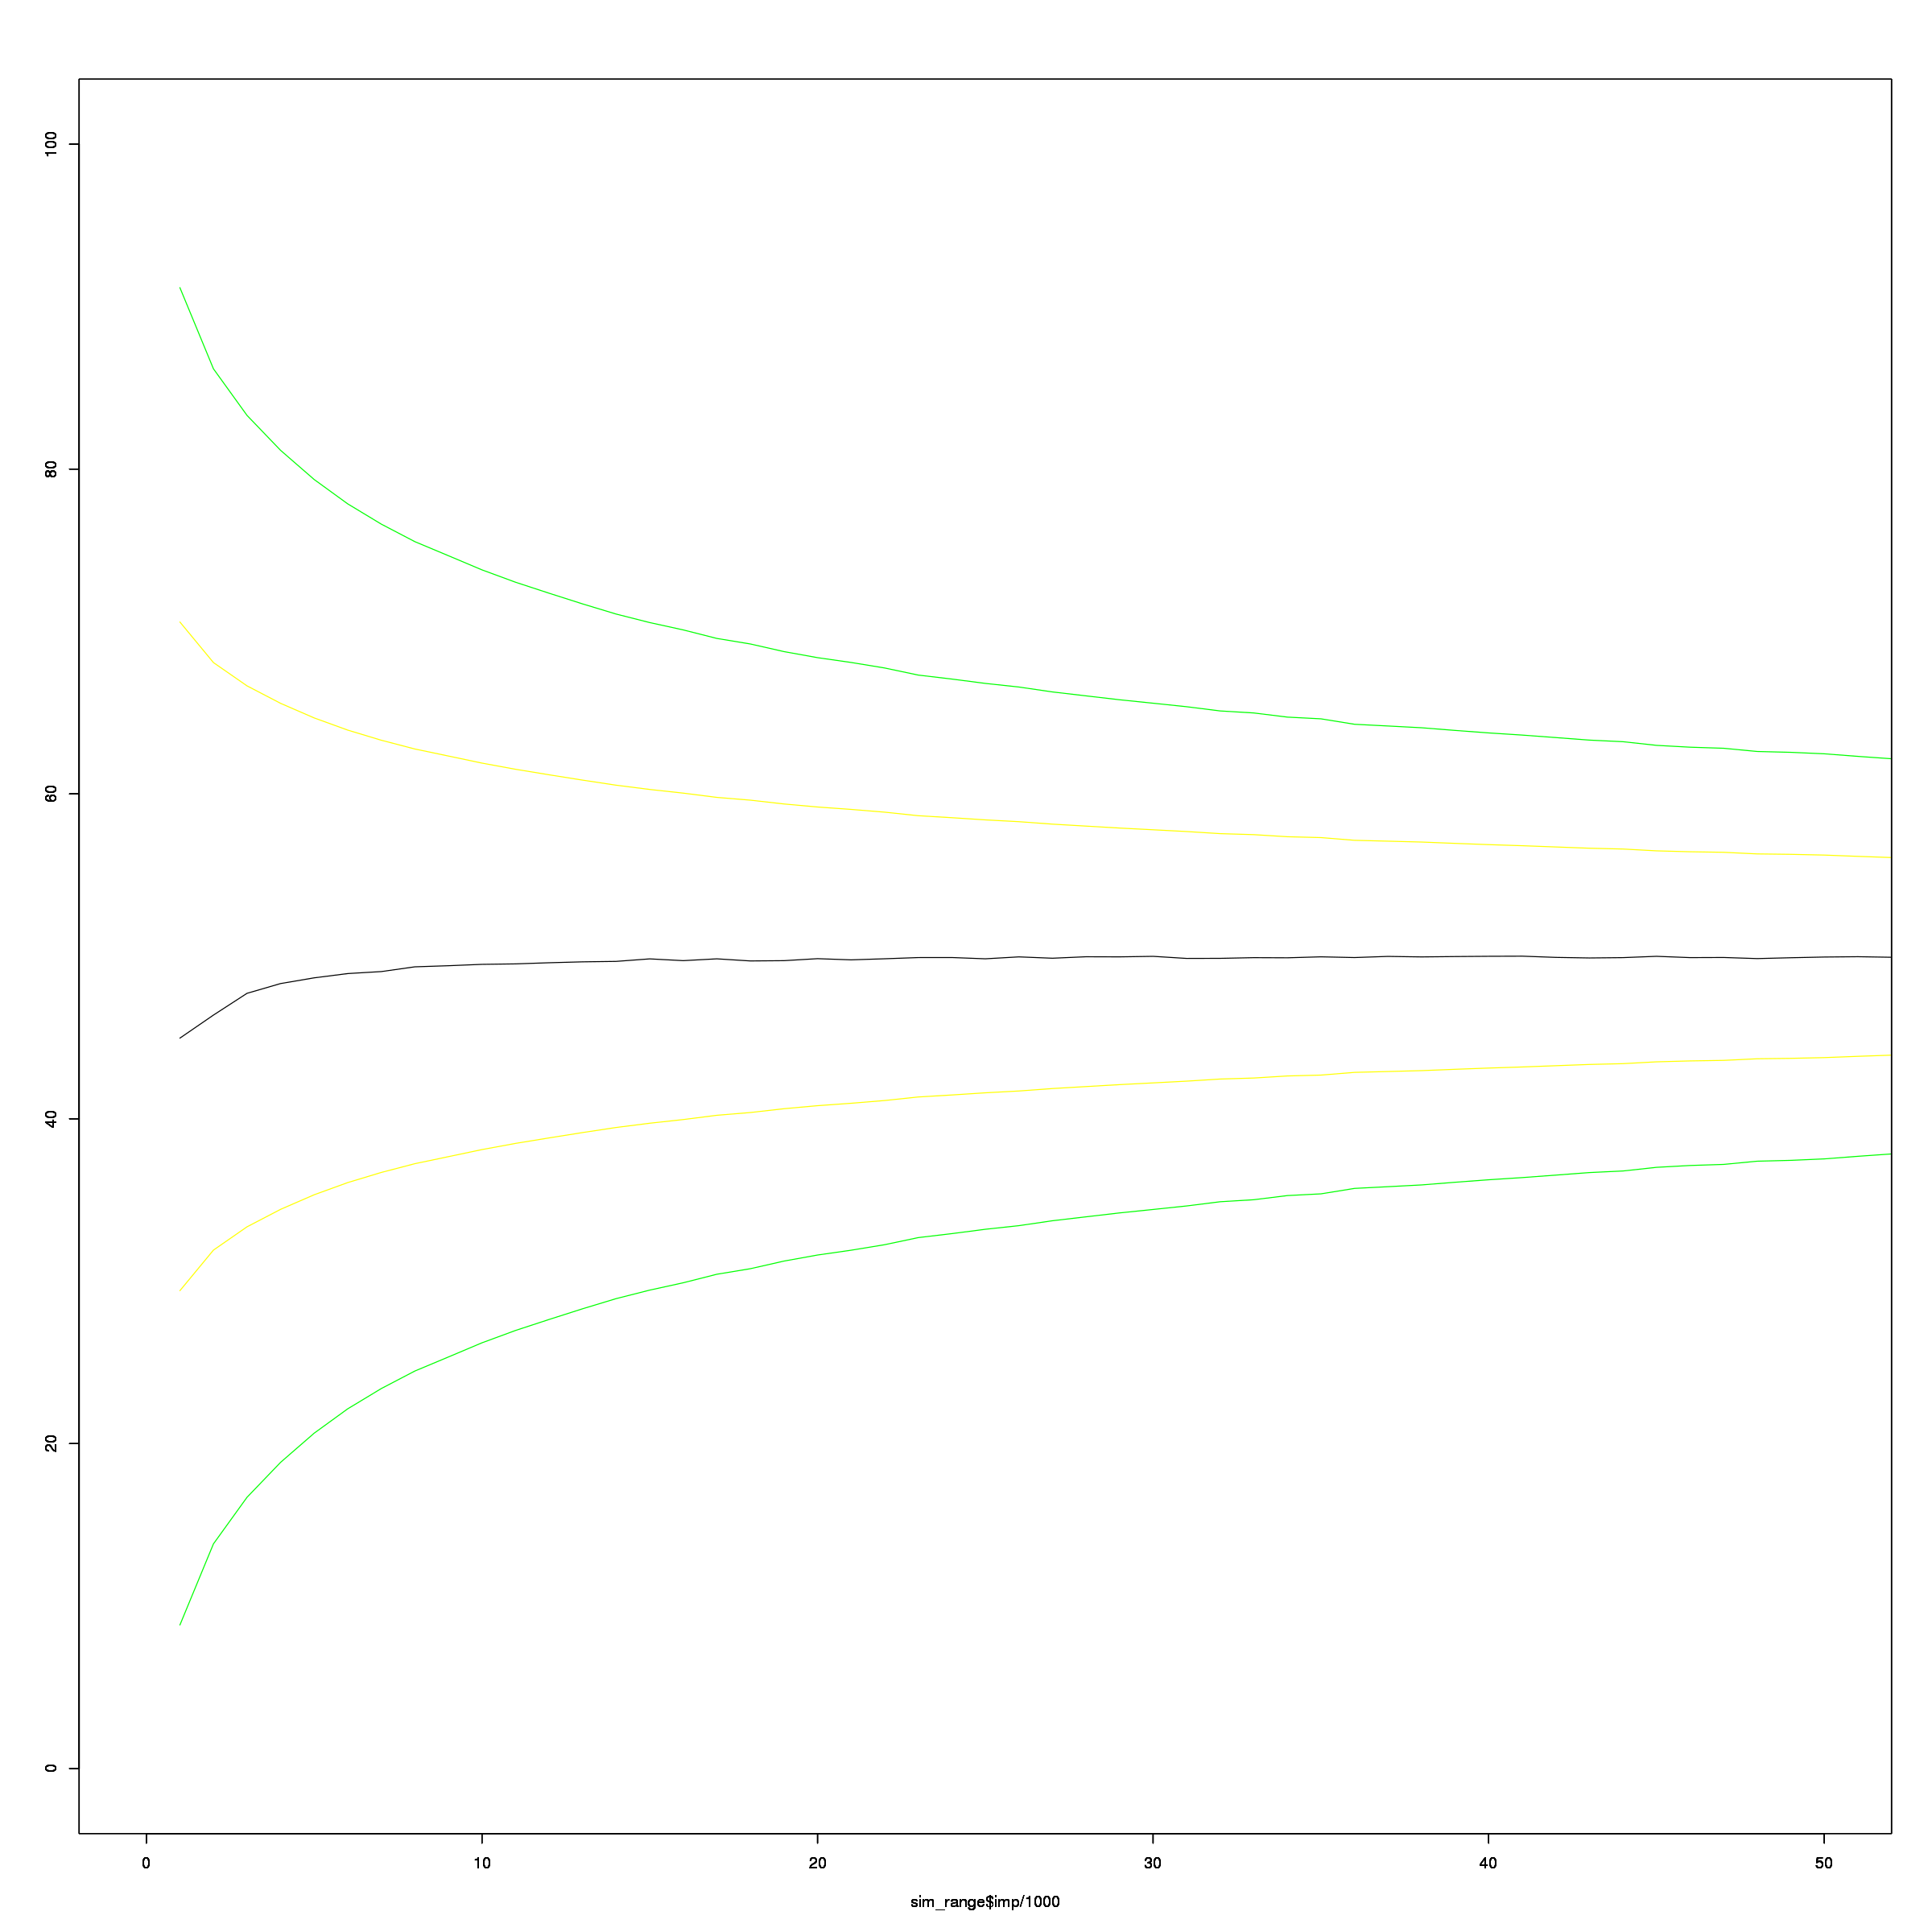

In [24]:
plot(sim_range$imp / 1000, 50 + sim_range$std_score , xlim = c(0, 50), ylim = c(0, 100), col = 'green', type = 'l', ylab = "")
par(new = T)
plot(sim_range$imp / 1000, 50 - sim_range$std_score , xlim = c(0, 50), ylim = c(0, 100), col = 'green', type = 'l', ylab = "")
par(new = T)
plot(sim_range$imp / 1000, sim_range$mean_score , xlim = c(0, 50), ylim = c(0, 100), col = 'black', type = 'l', ylab = "")
par(new = T)
plot(sim_range$imp / 1000, 50 + sim_range$std_score / 2 , xlim = c(0, 50), ylim = c(0, 100), col = 'yellow', type = 'l', ylab = "")
par(new = T)
plot(sim_range$imp / 1000, 50 - sim_range$std_score / 2 , xlim = c(0, 50), ylim = c(0, 100), col = 'yellow', type = 'l', ylab = "")

In [25]:
imp_tests <- c(seq(1000, 100000, 1000), seq(150000, 2000000, 50000))
mean_vtr <- 0.012090803
std_vtr <- 0.006399816
sim_range_dr <- data.frame()
#all_simulations <- data.frame()


In [26]:
for (i in imp_tests) {
    vt_sims <- rbinom(100000, i, mean_vtr)
    res <- data.frame(imp = i, std_rate = sd(vt_sims / i), mean_rate = mean(vt_sims / i), 
                      std_score = sd(pnorm(((vt_sims / i) - mean_vtr) / std_vtr) * 100),
                      mean_score = mean(pnorm(((vt_sims / i) - mean_vtr) / std_vtr) * 100)
                     )
    sim_range_dr <- rbind(sim_range_dr, res)
    }

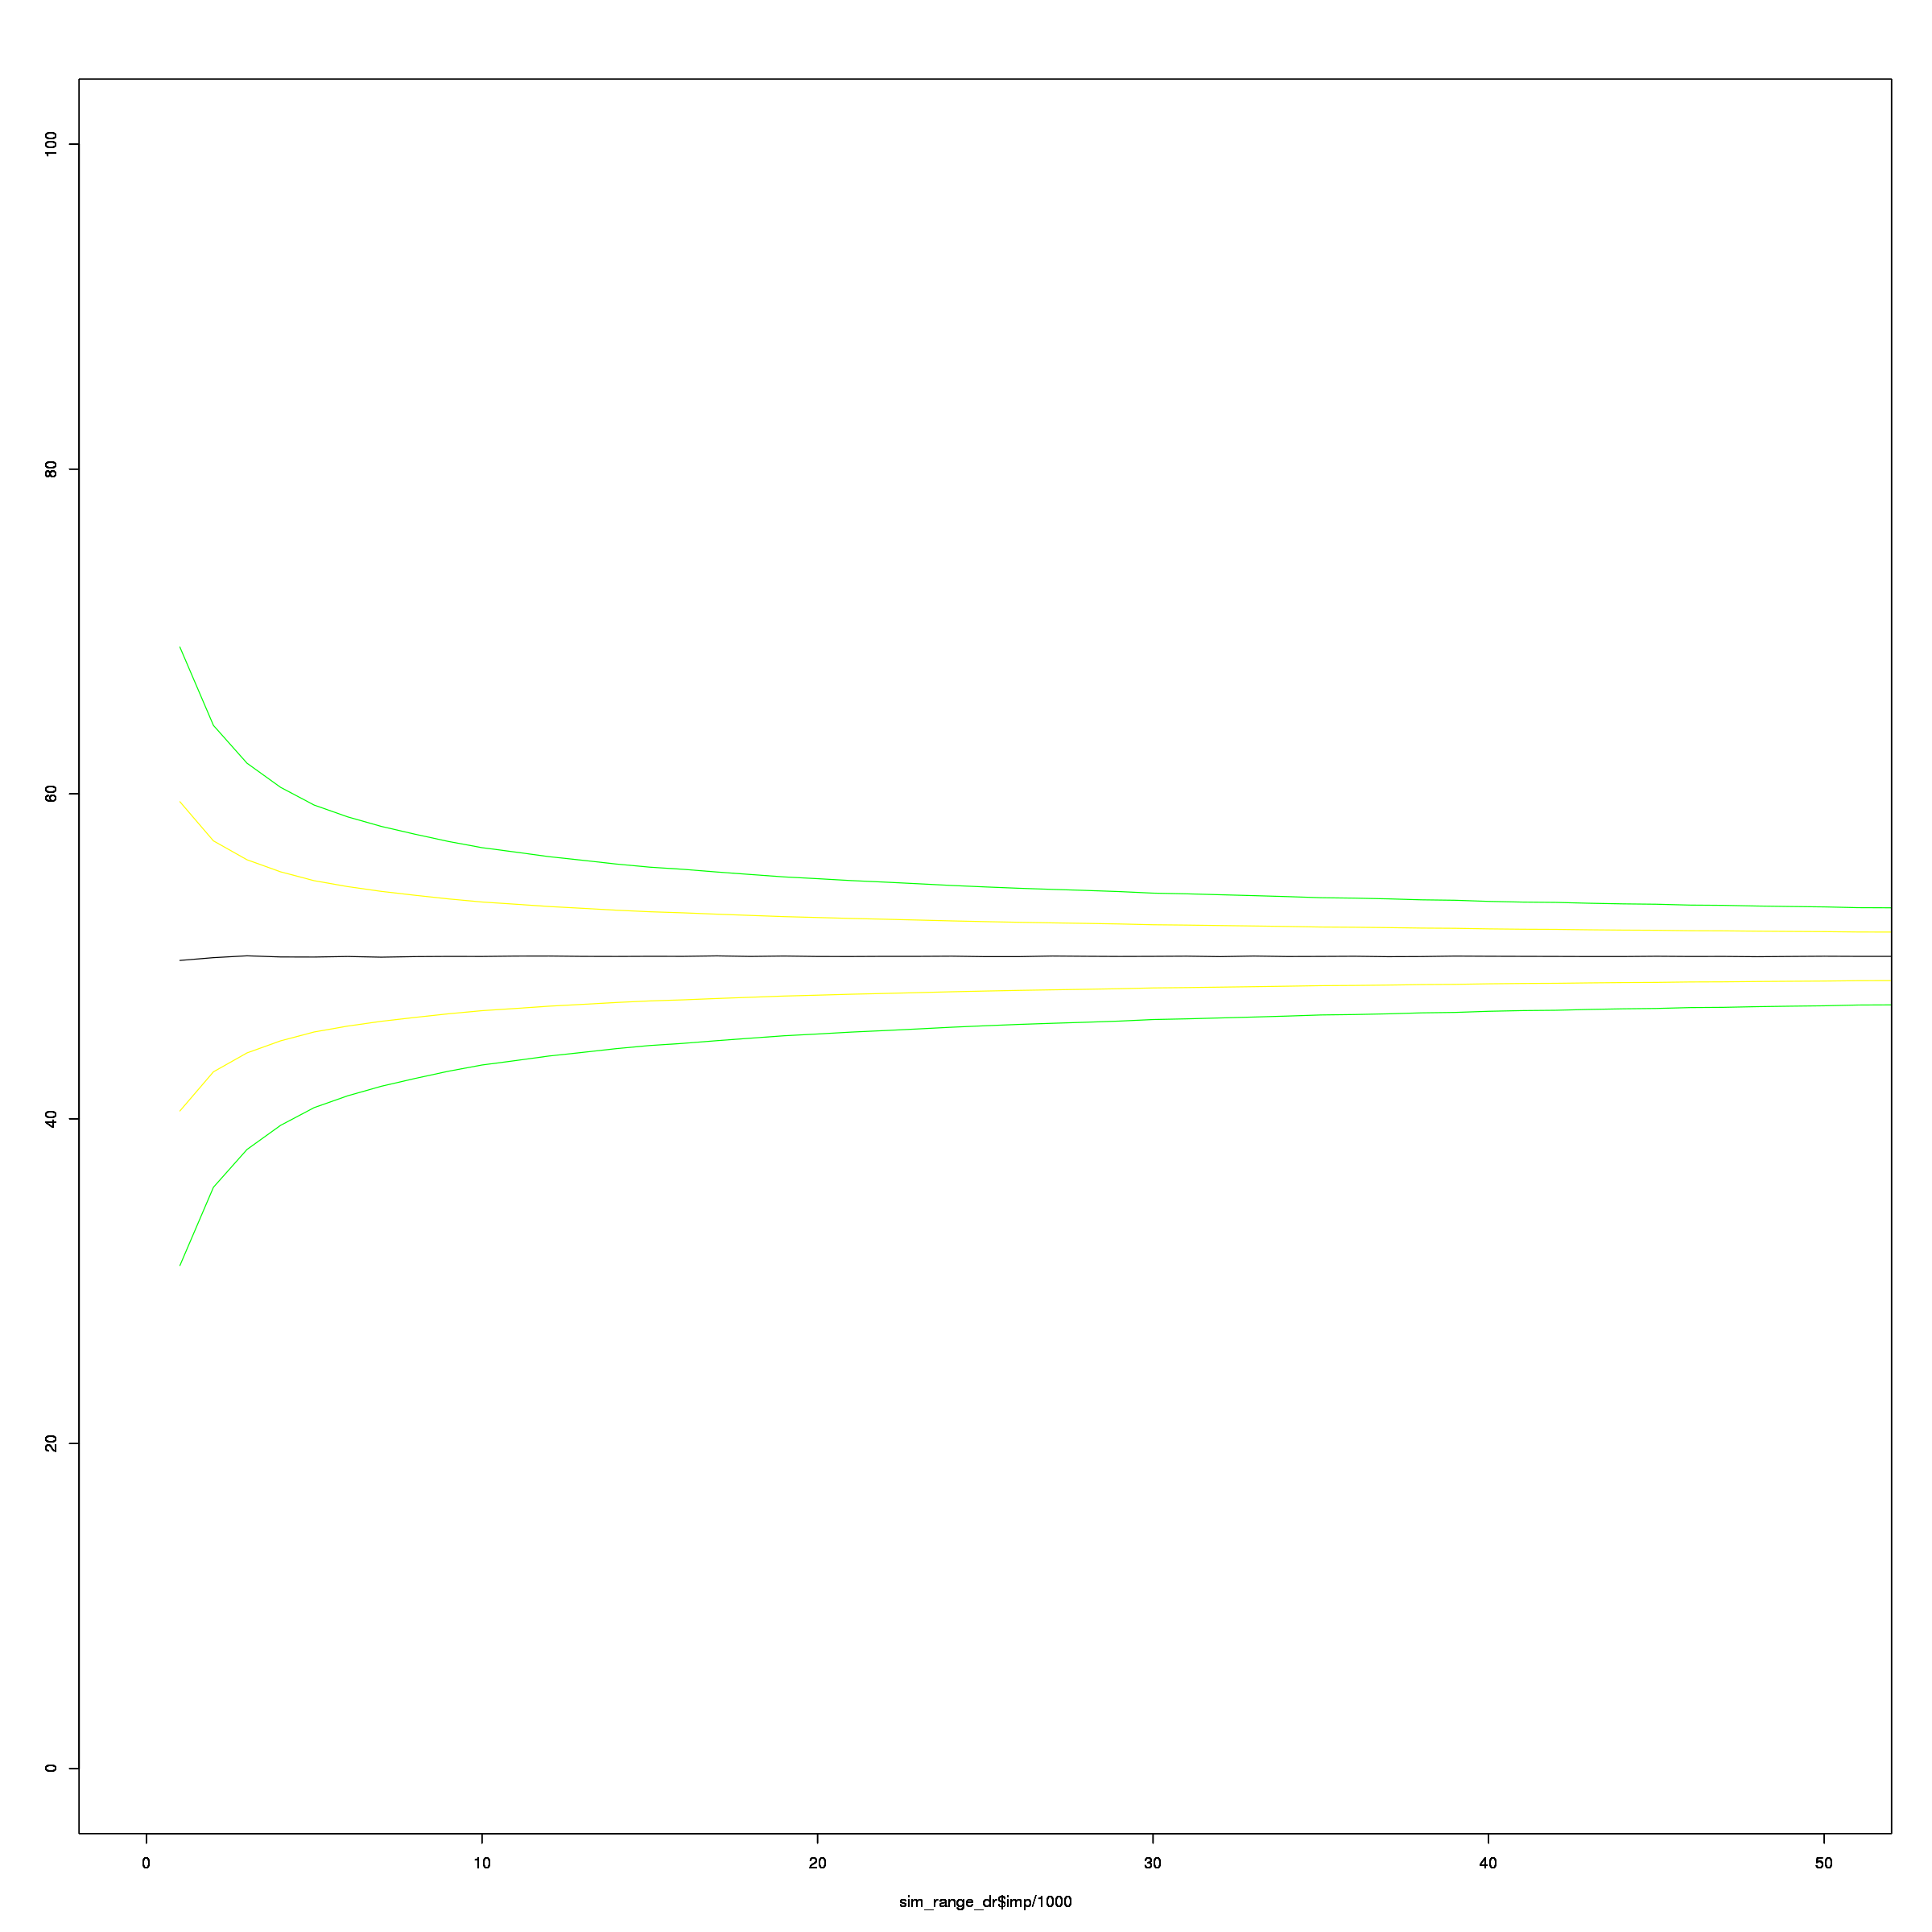

In [27]:
plot(sim_range_dr$imp / 1000, 50 + sim_range_dr$std_score , xlim =  c(0,50), ylim = c(0, 100), col = 'green', type = 'l', ylab = "")
par(new = T)
plot(sim_range_dr$imp / 1000, 50 - sim_range_dr$std_score , xlim =  c(0,50), ylim = c(0, 100), col = 'green', type = 'l', ylab = "")
par(new = T)
plot(sim_range_dr$imp / 1000, sim_range_dr$mean_score , xlim =  c(0,50), ylim = c(0, 100), col = 'black', type = 'l', ylab = "")
par(new = T)
plot(sim_range_dr$imp / 1000, 50 + sim_range_dr$std_score / 2 , xlim =  c(0,50), ylim = c(0, 100), col = 'yellow', type = 'l', ylab = "")
par(new = T)
plot(sim_range_dr$imp / 1000, 50 - sim_range_dr$std_score / 2 , xlim = c(0,50), ylim = c(0, 100), col = 'yellow', type = 'l', ylab = "")

In [28]:
#head(sim_range_dr)

In [29]:
# for (x in seq(0.1, 2, 0.1)) {
#     per_model <- (lm(std_score ~ 
#                      I(log(imp) ^ x)
#            #+ I((imp) ^ x) 
#             #+ I(imp ^ (1/3))
#            , data = sim_range_dr))
#     print(summary((per_model)))
#     }

In [30]:
per_model <- lm(formula = std_score ~ I(log(imp)) + I(imp ^ 0.2), data = sim_range_dr, weight = imp)
#summary(per_model)

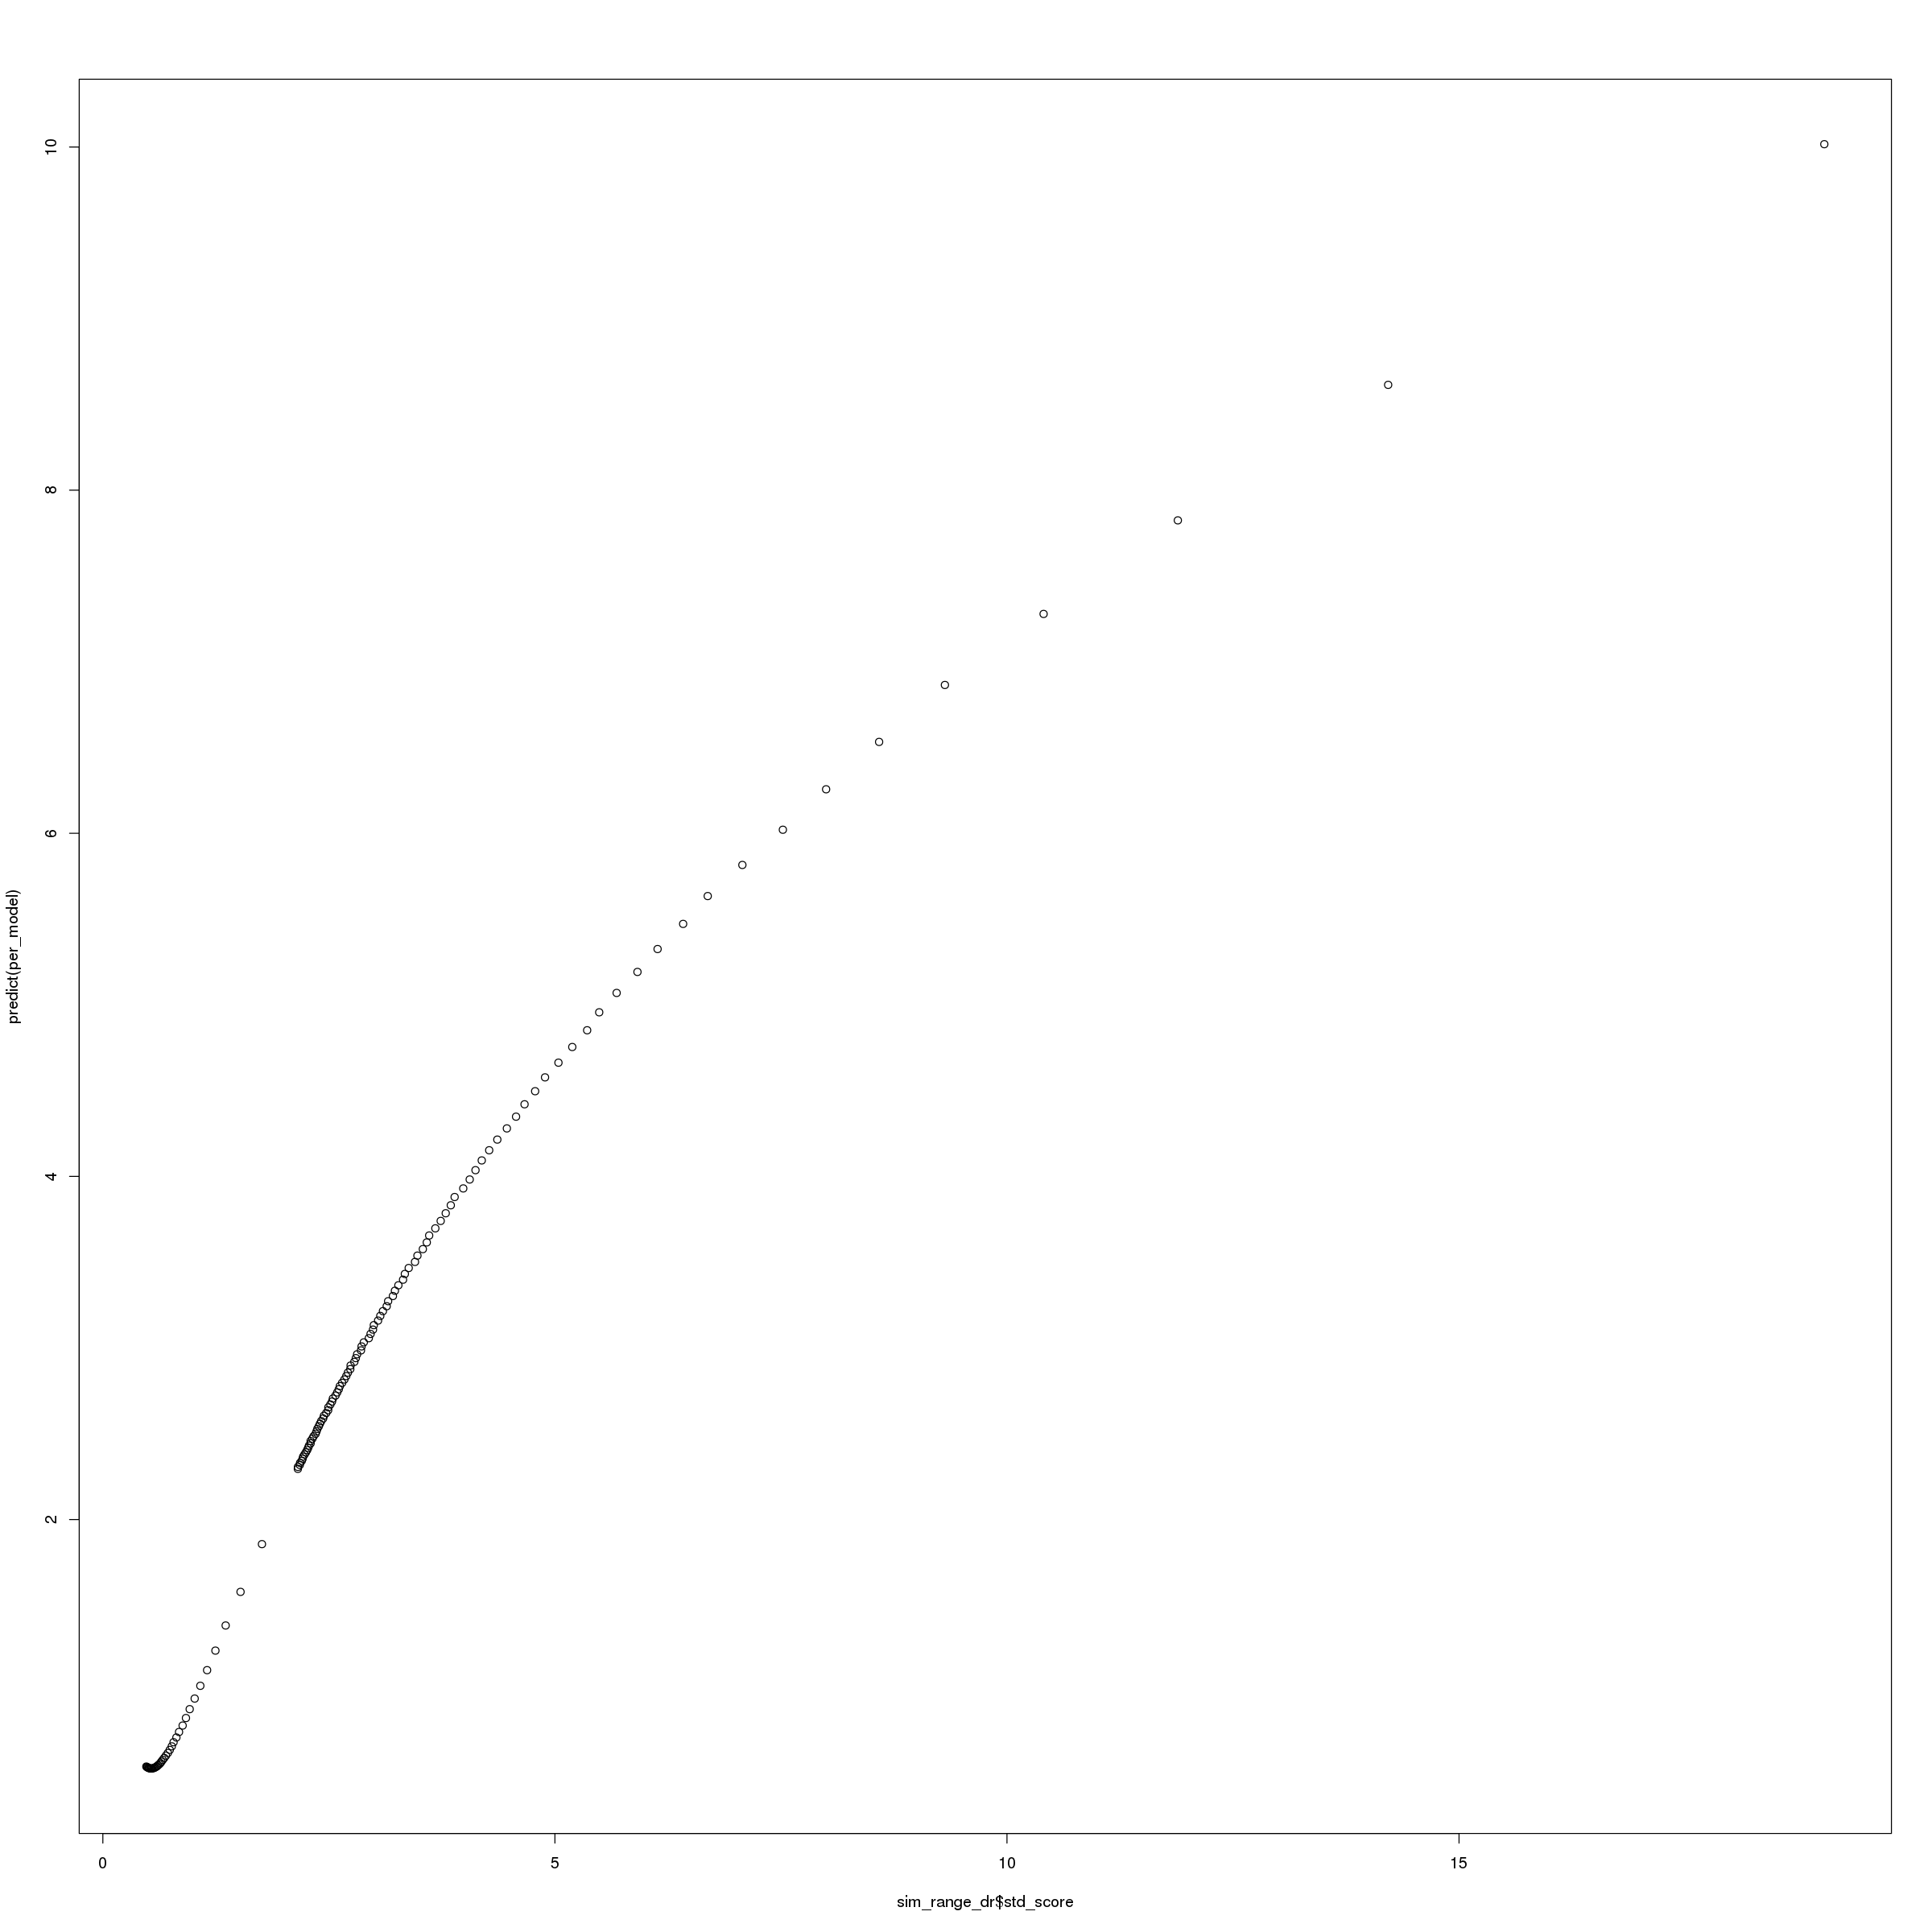

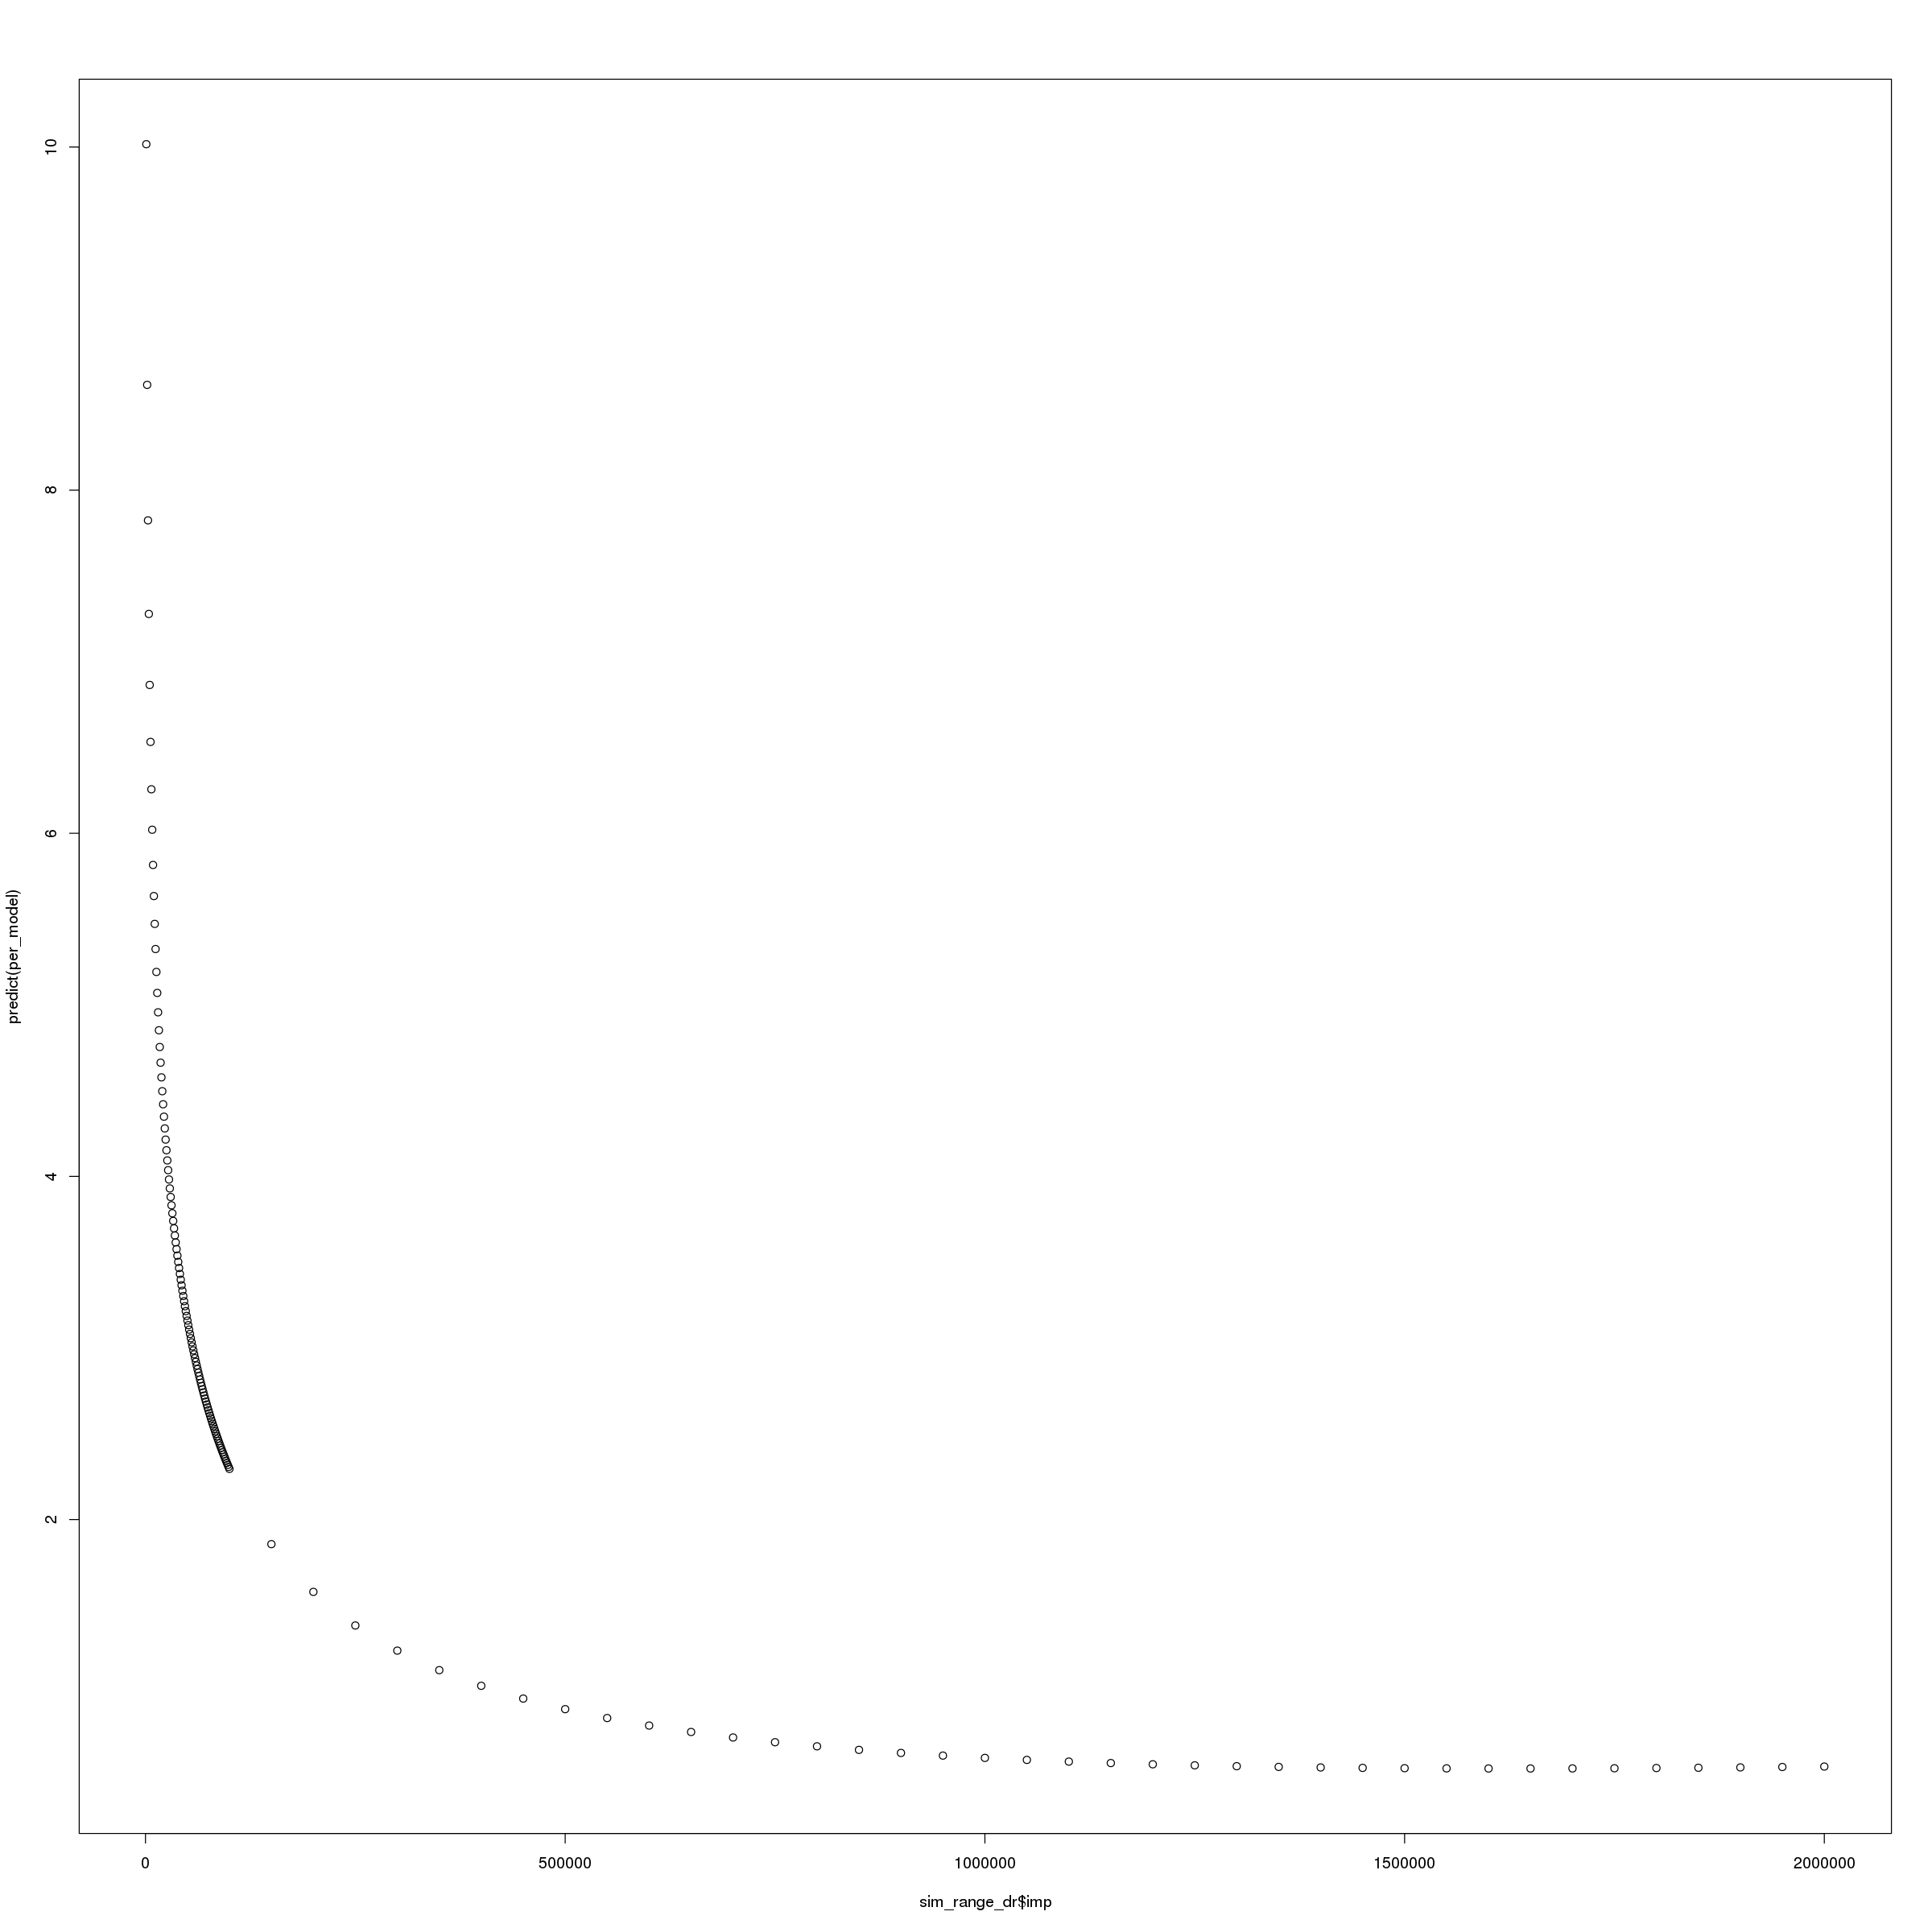

In [31]:
plot(sim_range_dr$std_score, predict(per_model))
plot(sim_range_dr$imp, predict(per_model))

In [32]:
std_dr_pred <- function(imp) {25.46279 + -2.67795 * (log(imp)) + 0.76627 * (imp ^ 0.2)}

In [33]:
std_dr_pred(10000)

[1] 5.632796

In [34]:
#sim_range
per_model_pr <- lm(formula = std_score ~ I(log(imp)) + I(imp ^ 0.2), data = sim_range, weight = imp)
#summary(per_model_pr)

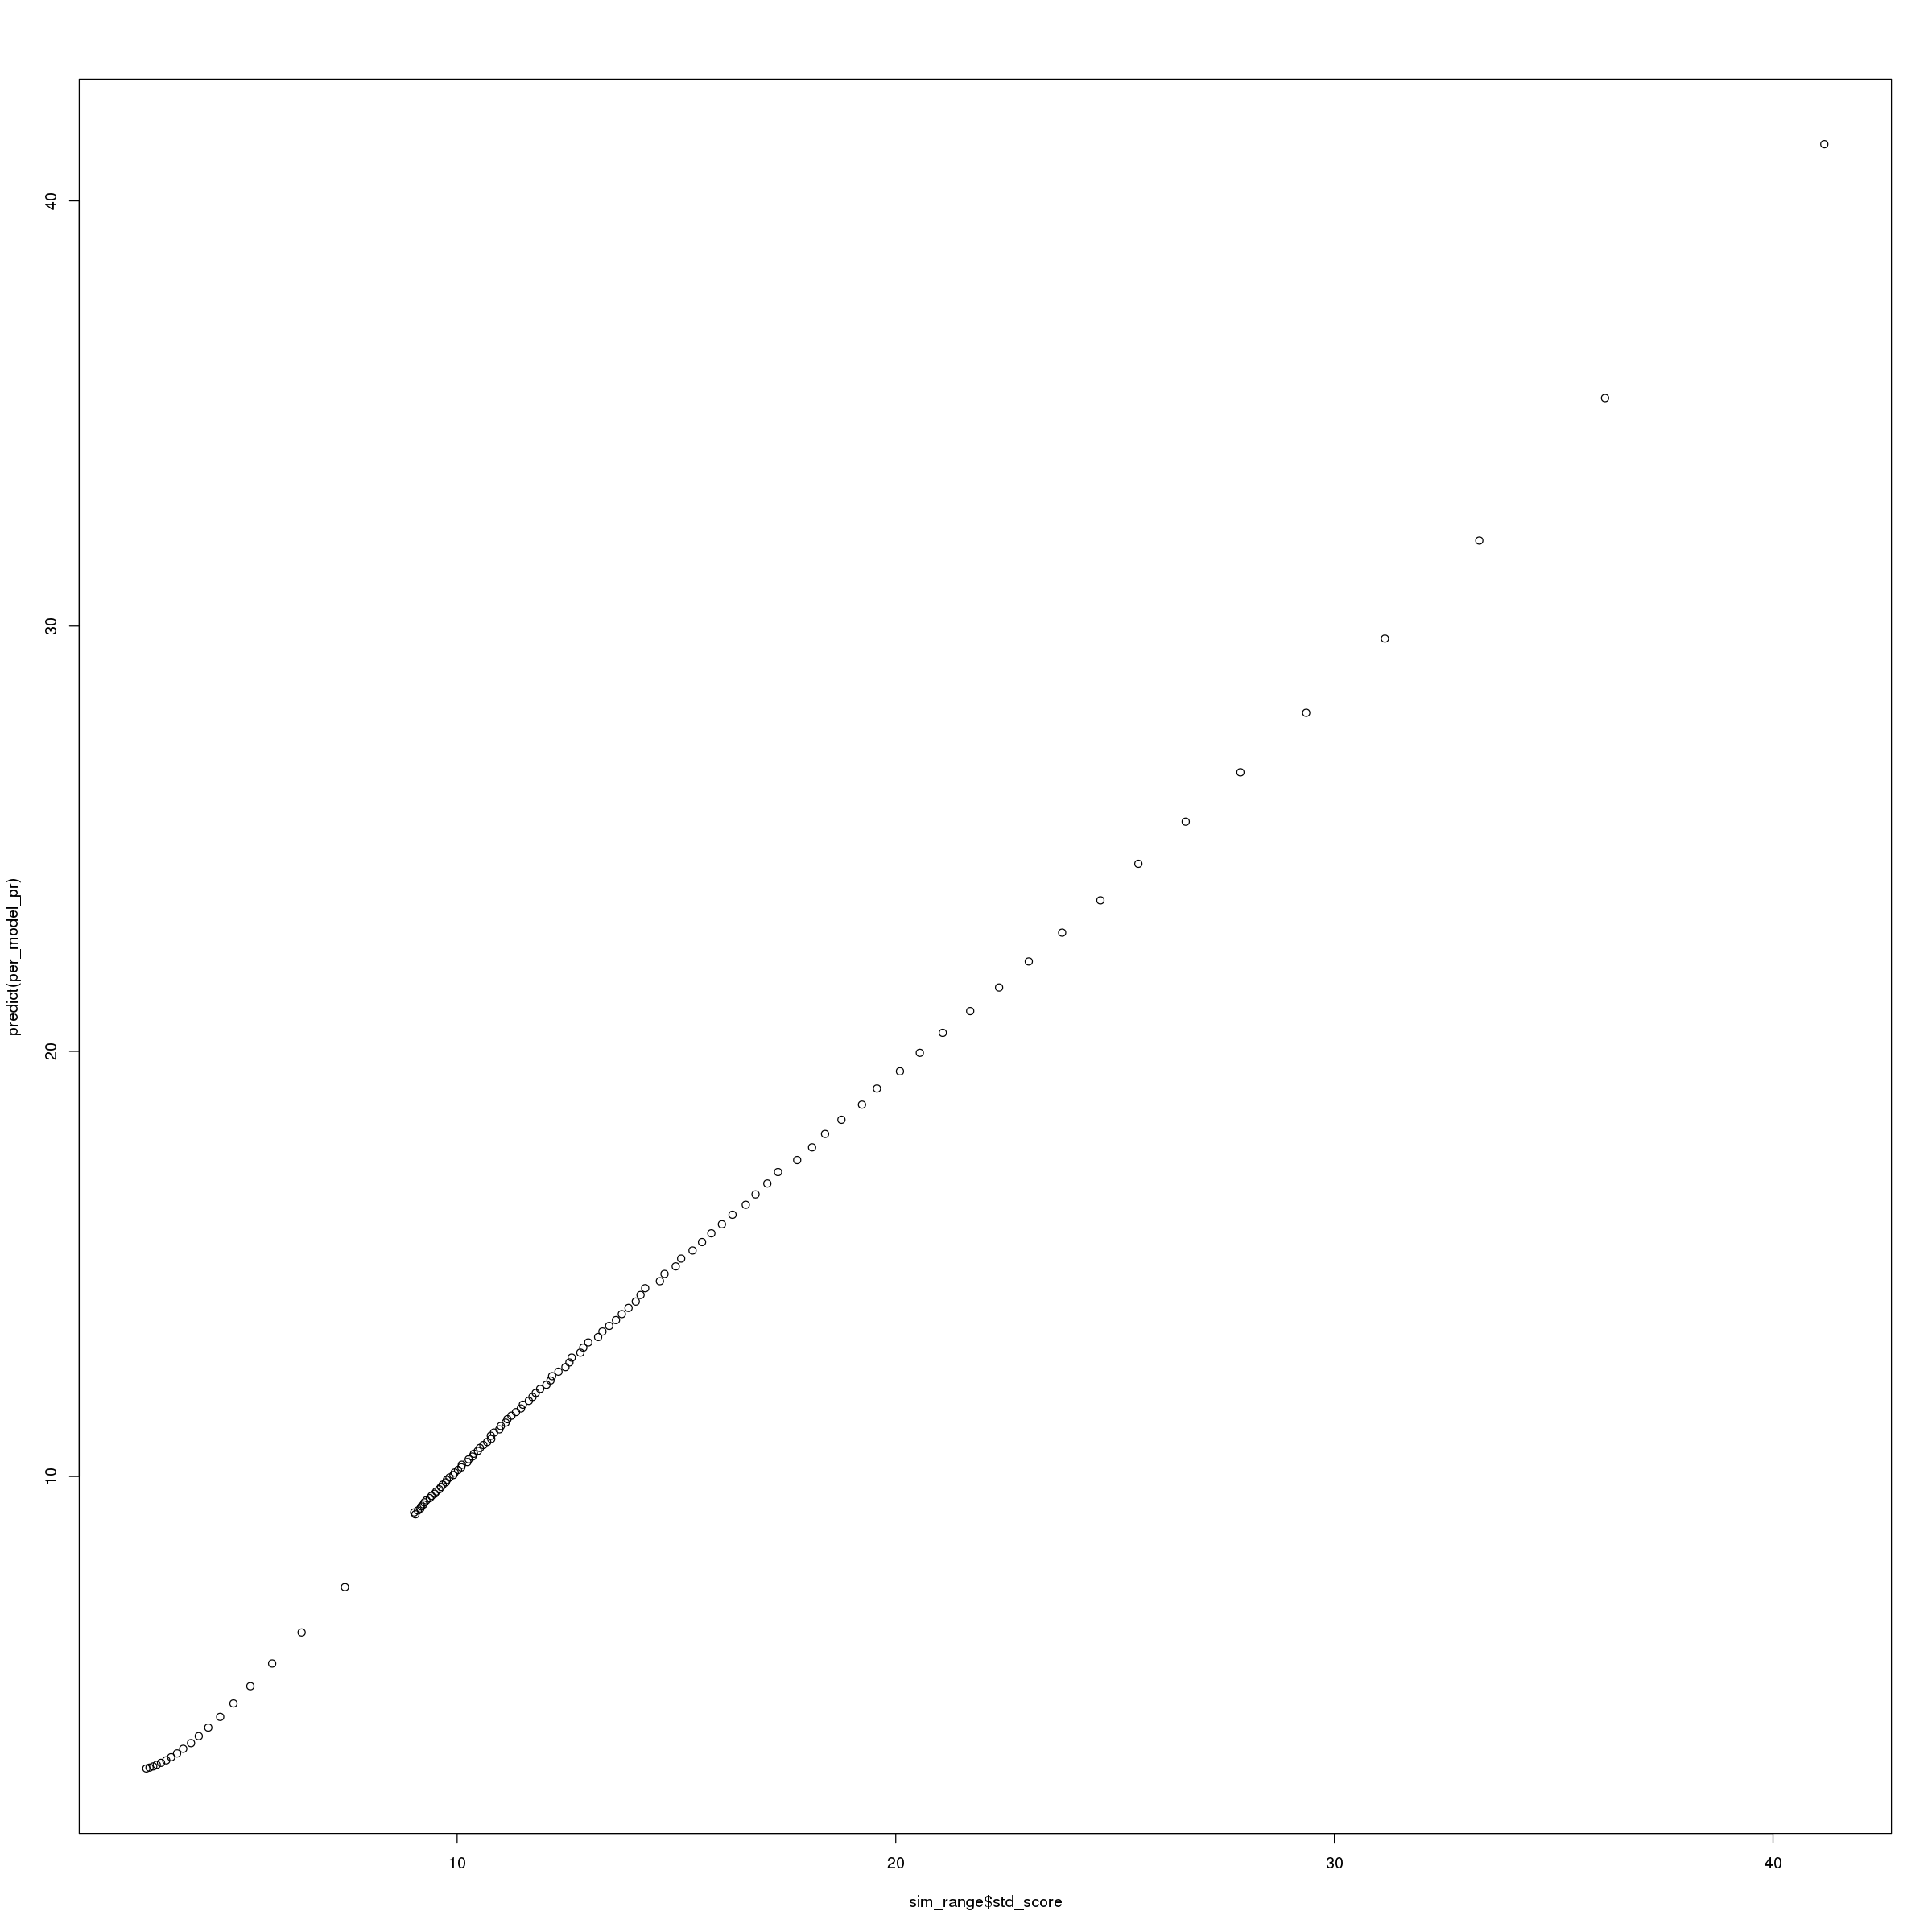

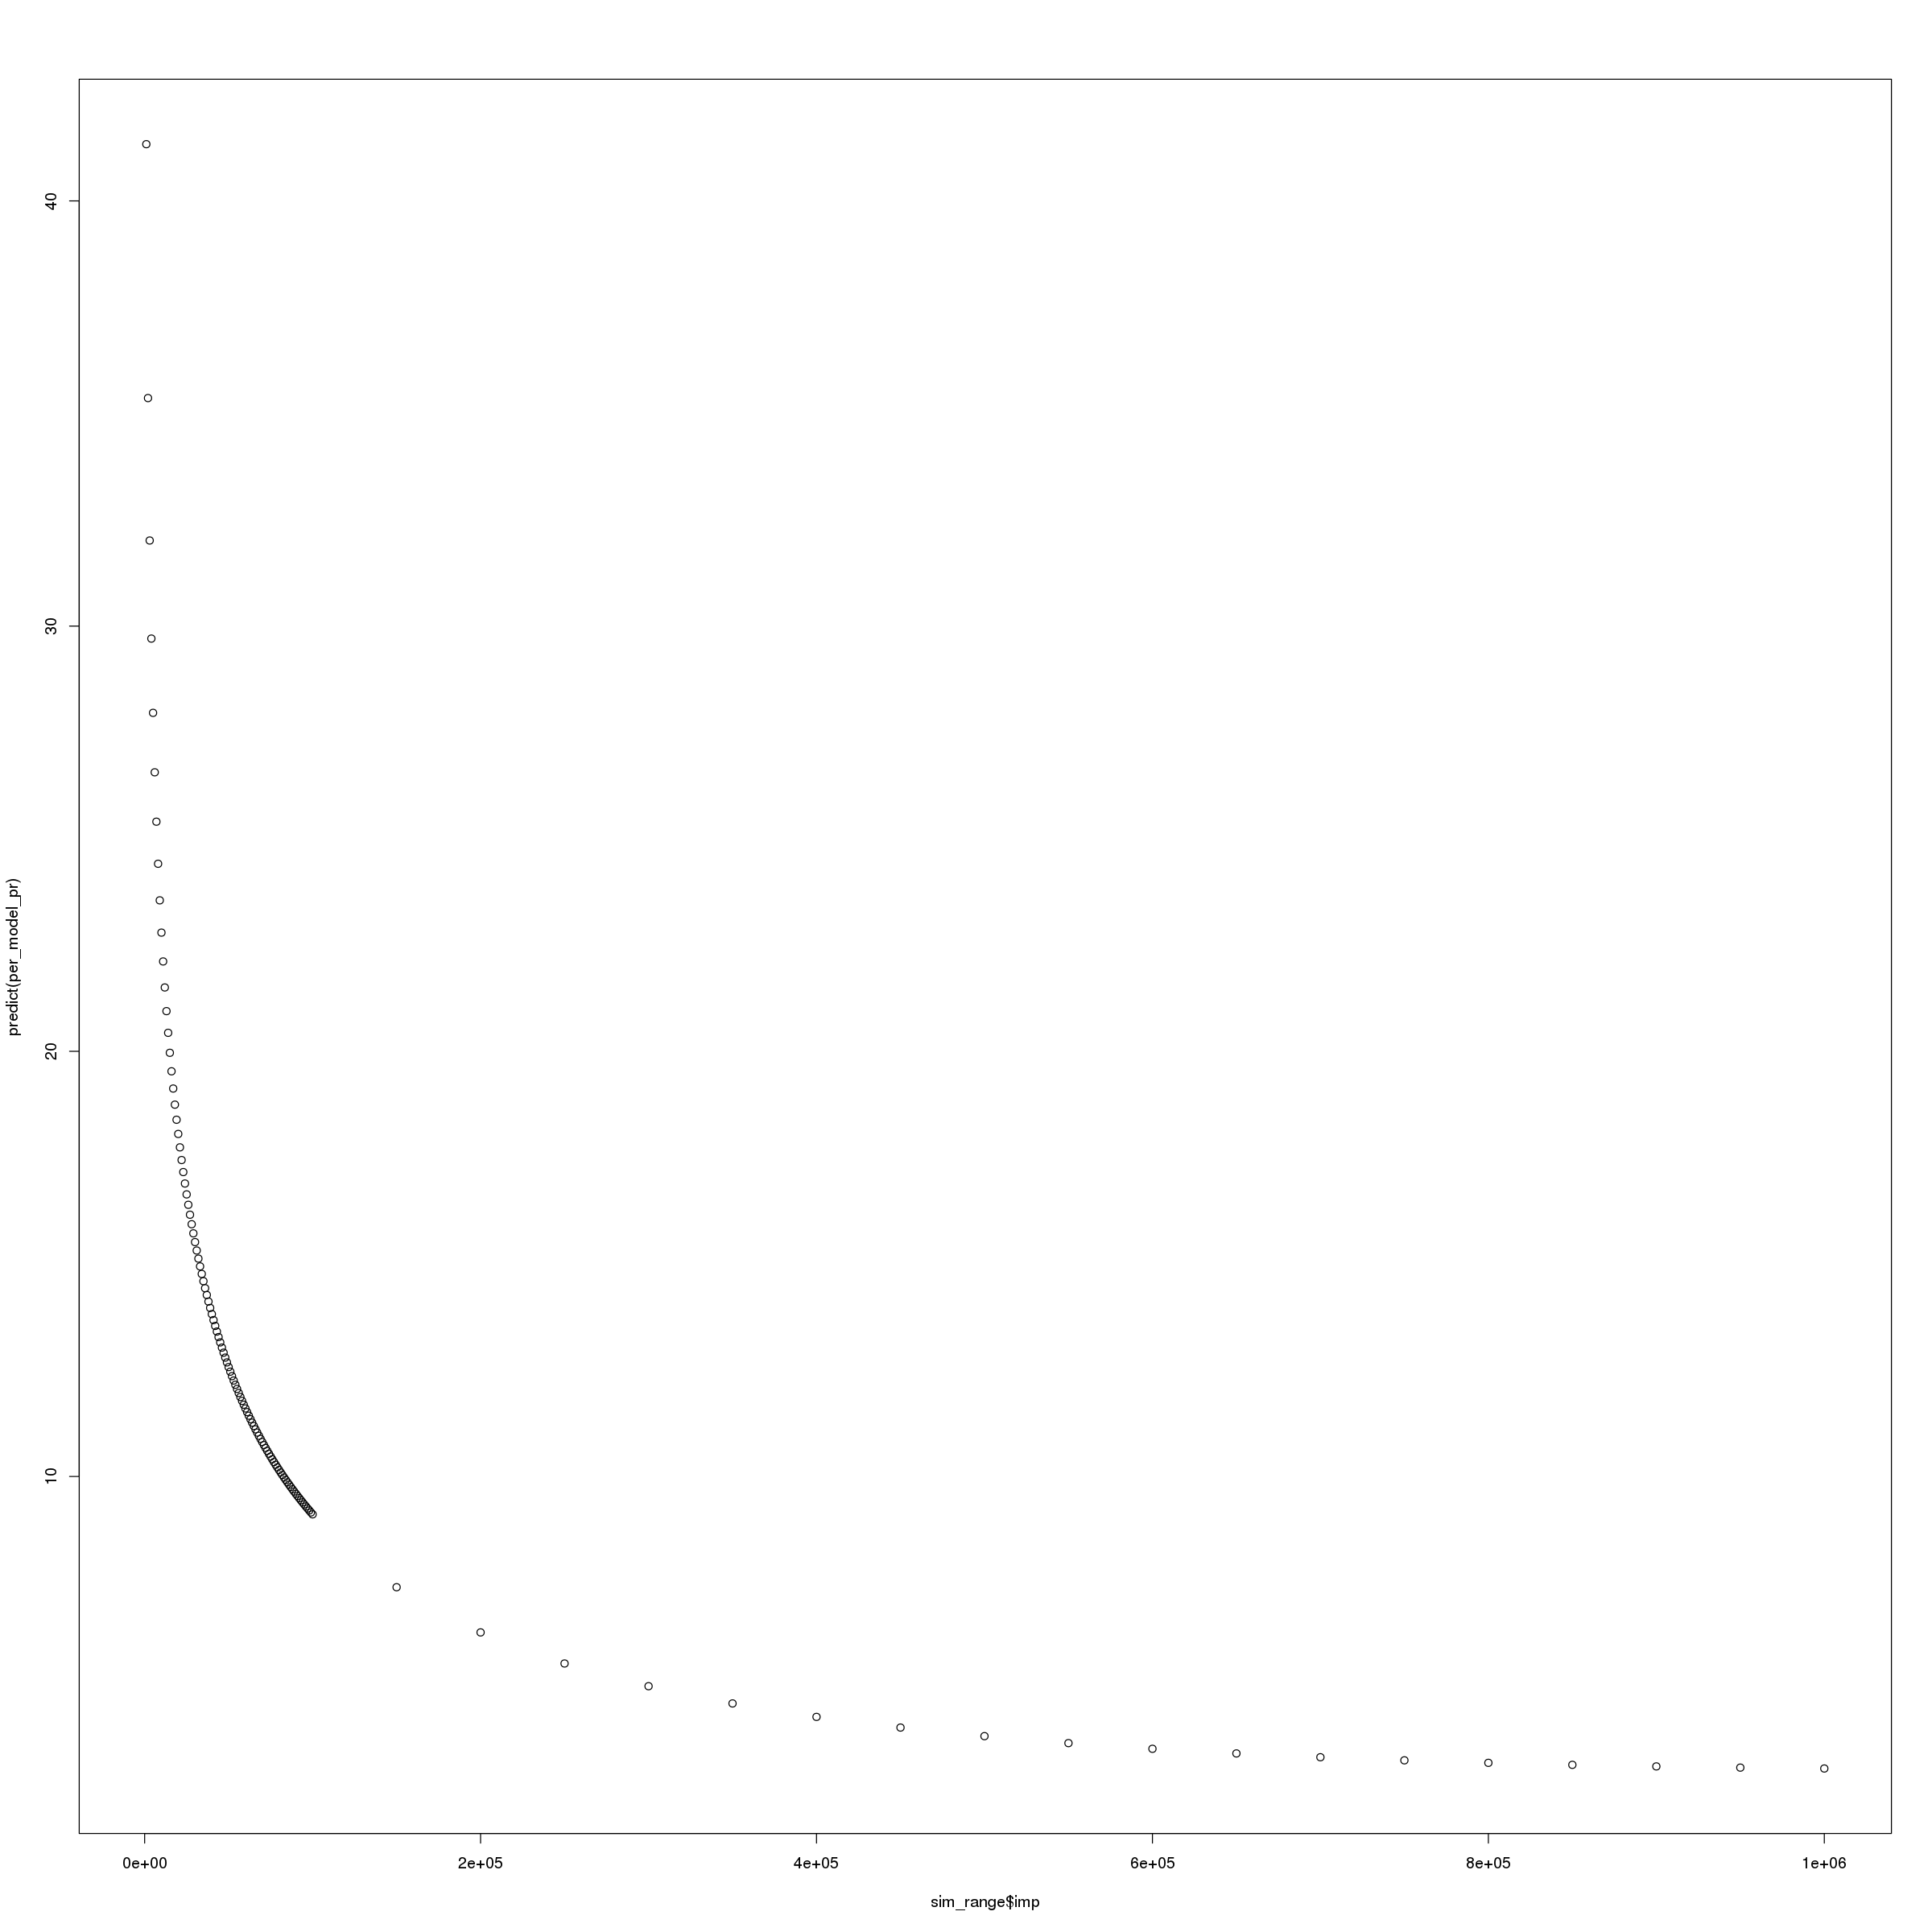

In [35]:
std_dr_pred <- function(imp) {25.46279 + -2.67795 * (log(imp)) + 0.76627 * (imp ^ 0.2)}
std_per_pred <- function(imp) {107.90340 + -11.69540 * (log(imp)) + 3.58461 * (imp ^ 0.2)}
plot(sim_range$std_score, predict(per_model_pr))
plot(sim_range$imp, predict(per_model_pr))

In [36]:
std_dr_pred(5000)
std_per_pred(10000)

[1] 6.863142

[1] 22.80215

In [37]:
head(fb_scores)

clean_name,objective,actual_objective,audience,state,dr_value,dr_value_avg,dr_value_std,bl_value_1,bl_value_1_avg,⋯,bl_value_2_std,z_dr,z_bl,impressions_7days,latest_date,dr_z_score,bl_1_z_score,dr_score,bl_1_score,imp_cut
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
mikeforblackamerica_69,REACH,Per,AA,Other,0.0115637463,0.0199963223,1.861320e-02,0.0002142357,0.0004181161,⋯,0.01861320,-0.4530428,-0.67297918,271034,2020-02-28,-0.4530428,-0.8929155,32.52589,18.59512,group20max4473141-
honoringblackhistory_79,REACH,Per,AA,Other,0.0116522913,0.0199963223,1.861320e-02,0.0005994428,0.0004181161,⋯,0.01861320,-0.4482857,0.17292673,271276,2020-02-28,-0.4482857,0.7941392,32.69735,78.64428,group20max4473141-
legacyofblackwallstreet_1:20,REACH,Per,AA,Other,0.0063554135,0.0128608564,6.983320e-03,0.0006567651,0.0004182253,⋯,0.00698332,-0.9315688,0.11432948,72457,2020-02-22,-0.9315688,1.1602277,17.57797,87.70219,group19max90568-
manager,REACH,Per,AL,Alabama,0.0195789450,0.0128608564,6.983320e-03,0.0002720872,0.0004182253,⋯,0.00698332,0.9620193,0.12561114,88207,2020-02-25,0.9620193,-0.7107970,83.19800,23.86050,group19max90568-
getitdone,REACH,Per,AL,Alabama,0.0175079648,0.0128608564,6.983320e-03,0.0002922866,0.0004182253,⋯,0.00698332,0.6654583,0.02645411,205278,2020-02-26,0.6654583,-0.6125501,74.71213,27.00869,group20max4473141-
getitdone,REACH,Per,AL,Alabama,0.0002922866,0.0002989183,3.153685e-05,0.0002922866,0.0002989183,⋯,NA,-0.2102853,-0.21028534,205278,2020-02-26,-0.2102853,-0.2102853,41.67225,41.67225,group20max4473141-


In [38]:
ddply(subset(fb_scores), .(actual_objective, objective), summarize,  
      mean_dr_avg = mean(dr_value_avg), std_dr_avg = sd(dr_value_avg), 
      mean_bl_1_avg = mean(bl_value_1_avg), std_bl_1_avg = sd(bl_value_1_avg), mean_bl_1_std = mean(bl_value_1_std),
      mean_bl_2_avg = mean(bl_value_2_avg), std_bl_2_avg = sd(bl_value_2_avg), mean_bl_2_std = mean(bl_value_2_std)
     )

actual_objective,objective,mean_dr_avg,std_dr_avg,mean_bl_1_avg,std_bl_1_avg,mean_bl_1_std,mean_bl_2_avg,std_bl_2_avg,mean_bl_2_std
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DR,CONVERSIONS,0.003747885,0.0002021252,0.0008221257,2.360322e-05,0.0006579798,NA,NA,NA
DR,EVENT_RESPONSES,0.002982904,0.0000000000,0.0006118526,0.000000e+00,0.0003810681,NA,NA,NA
DR,LINK_CLICKS,0.014965837,0.0027608438,0.0010054733,7.299120e-05,0.0013814285,NA,NA,NA
Per,LINK_CLICKS,0.002721764,0.0002176953,0.0007493426,6.584913e-05,0.0003563494,NA,NA,NA
Per,REACH,0.010971958,0.0087103836,0.0003606658,6.888560e-05,0.0001409959,NA,NA,NA


In [51]:
imp_tests <- c(seq(1000, 100000, 1000), seq(150000, 2000000, 50000))
mean_vtr <- 0.002778432
std_vtr <- 0.0002587341
sim_range_con <- data.frame()

In [52]:
for (i in imp_tests) {
    vt_sims <- rbinom(100000, i, mean_vtr)
    res <- data.frame(imp = i, std_rate = sd(vt_sims / i), mean_rate = mean(vt_sims / i), 
                      std_score = sd(pnorm(((vt_sims / i) - mean_vtr) / std_vtr) * 100),
                      mean_score = mean(pnorm(((vt_sims / i) - mean_vtr) / std_vtr) * 100)
                     )
    sim_range_con <- rbind(sim_range_con, res)
    }

In [53]:
head(sim_range_con)

,imp,std_rate,mean_rate,std_score,mean_score
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000,0.0016687776,0.002773110,46.32789,48.05568
2,2000,0.0011801319,0.002783055,45.06330,47.59925
3,3000,0.0009607078,0.002783280,43.71648,48.09456
4,4000,0.0008329585,0.002781970,42.74367,48.38818
5,5000,0.0007415905,0.002775548,41.86606,48.38059
6,6000,0.0006769335,0.002778343,41.09469,48.68120


In [42]:
per_model_con <- lm(formula = std_score ~ I(log(imp)) + I(imp ^ 0.2), data = sim_range_con, weight = imp)

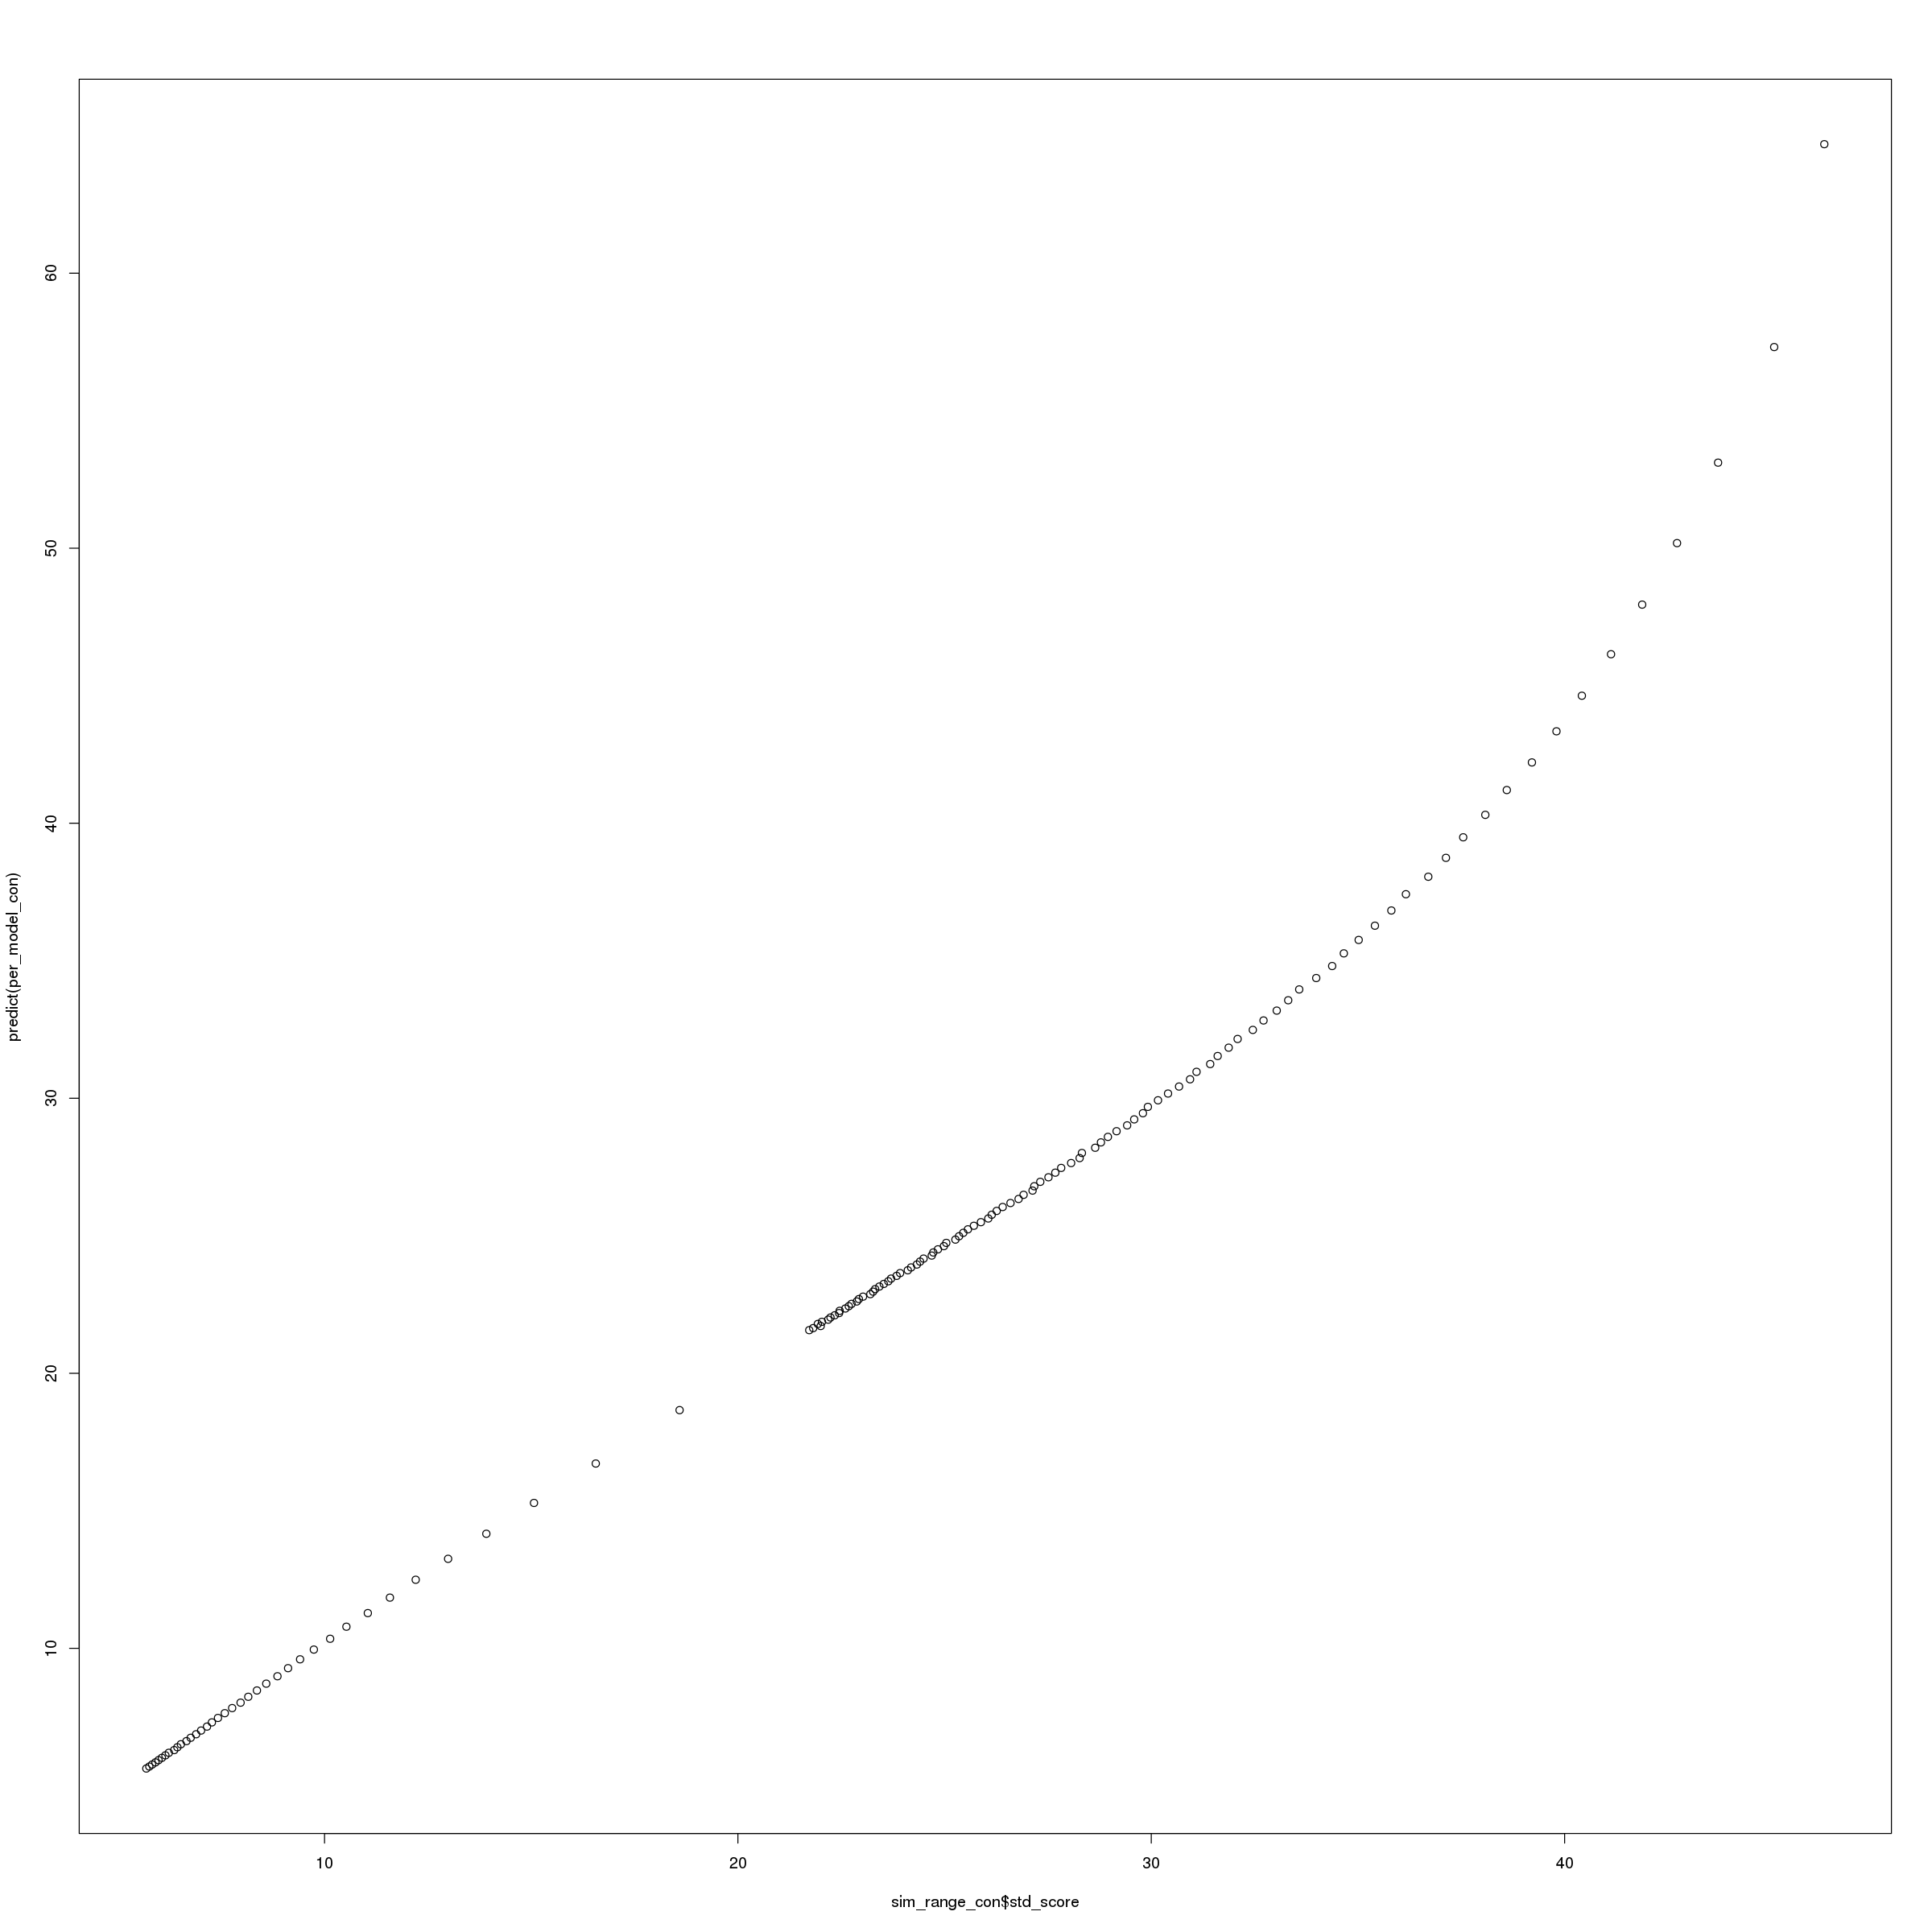

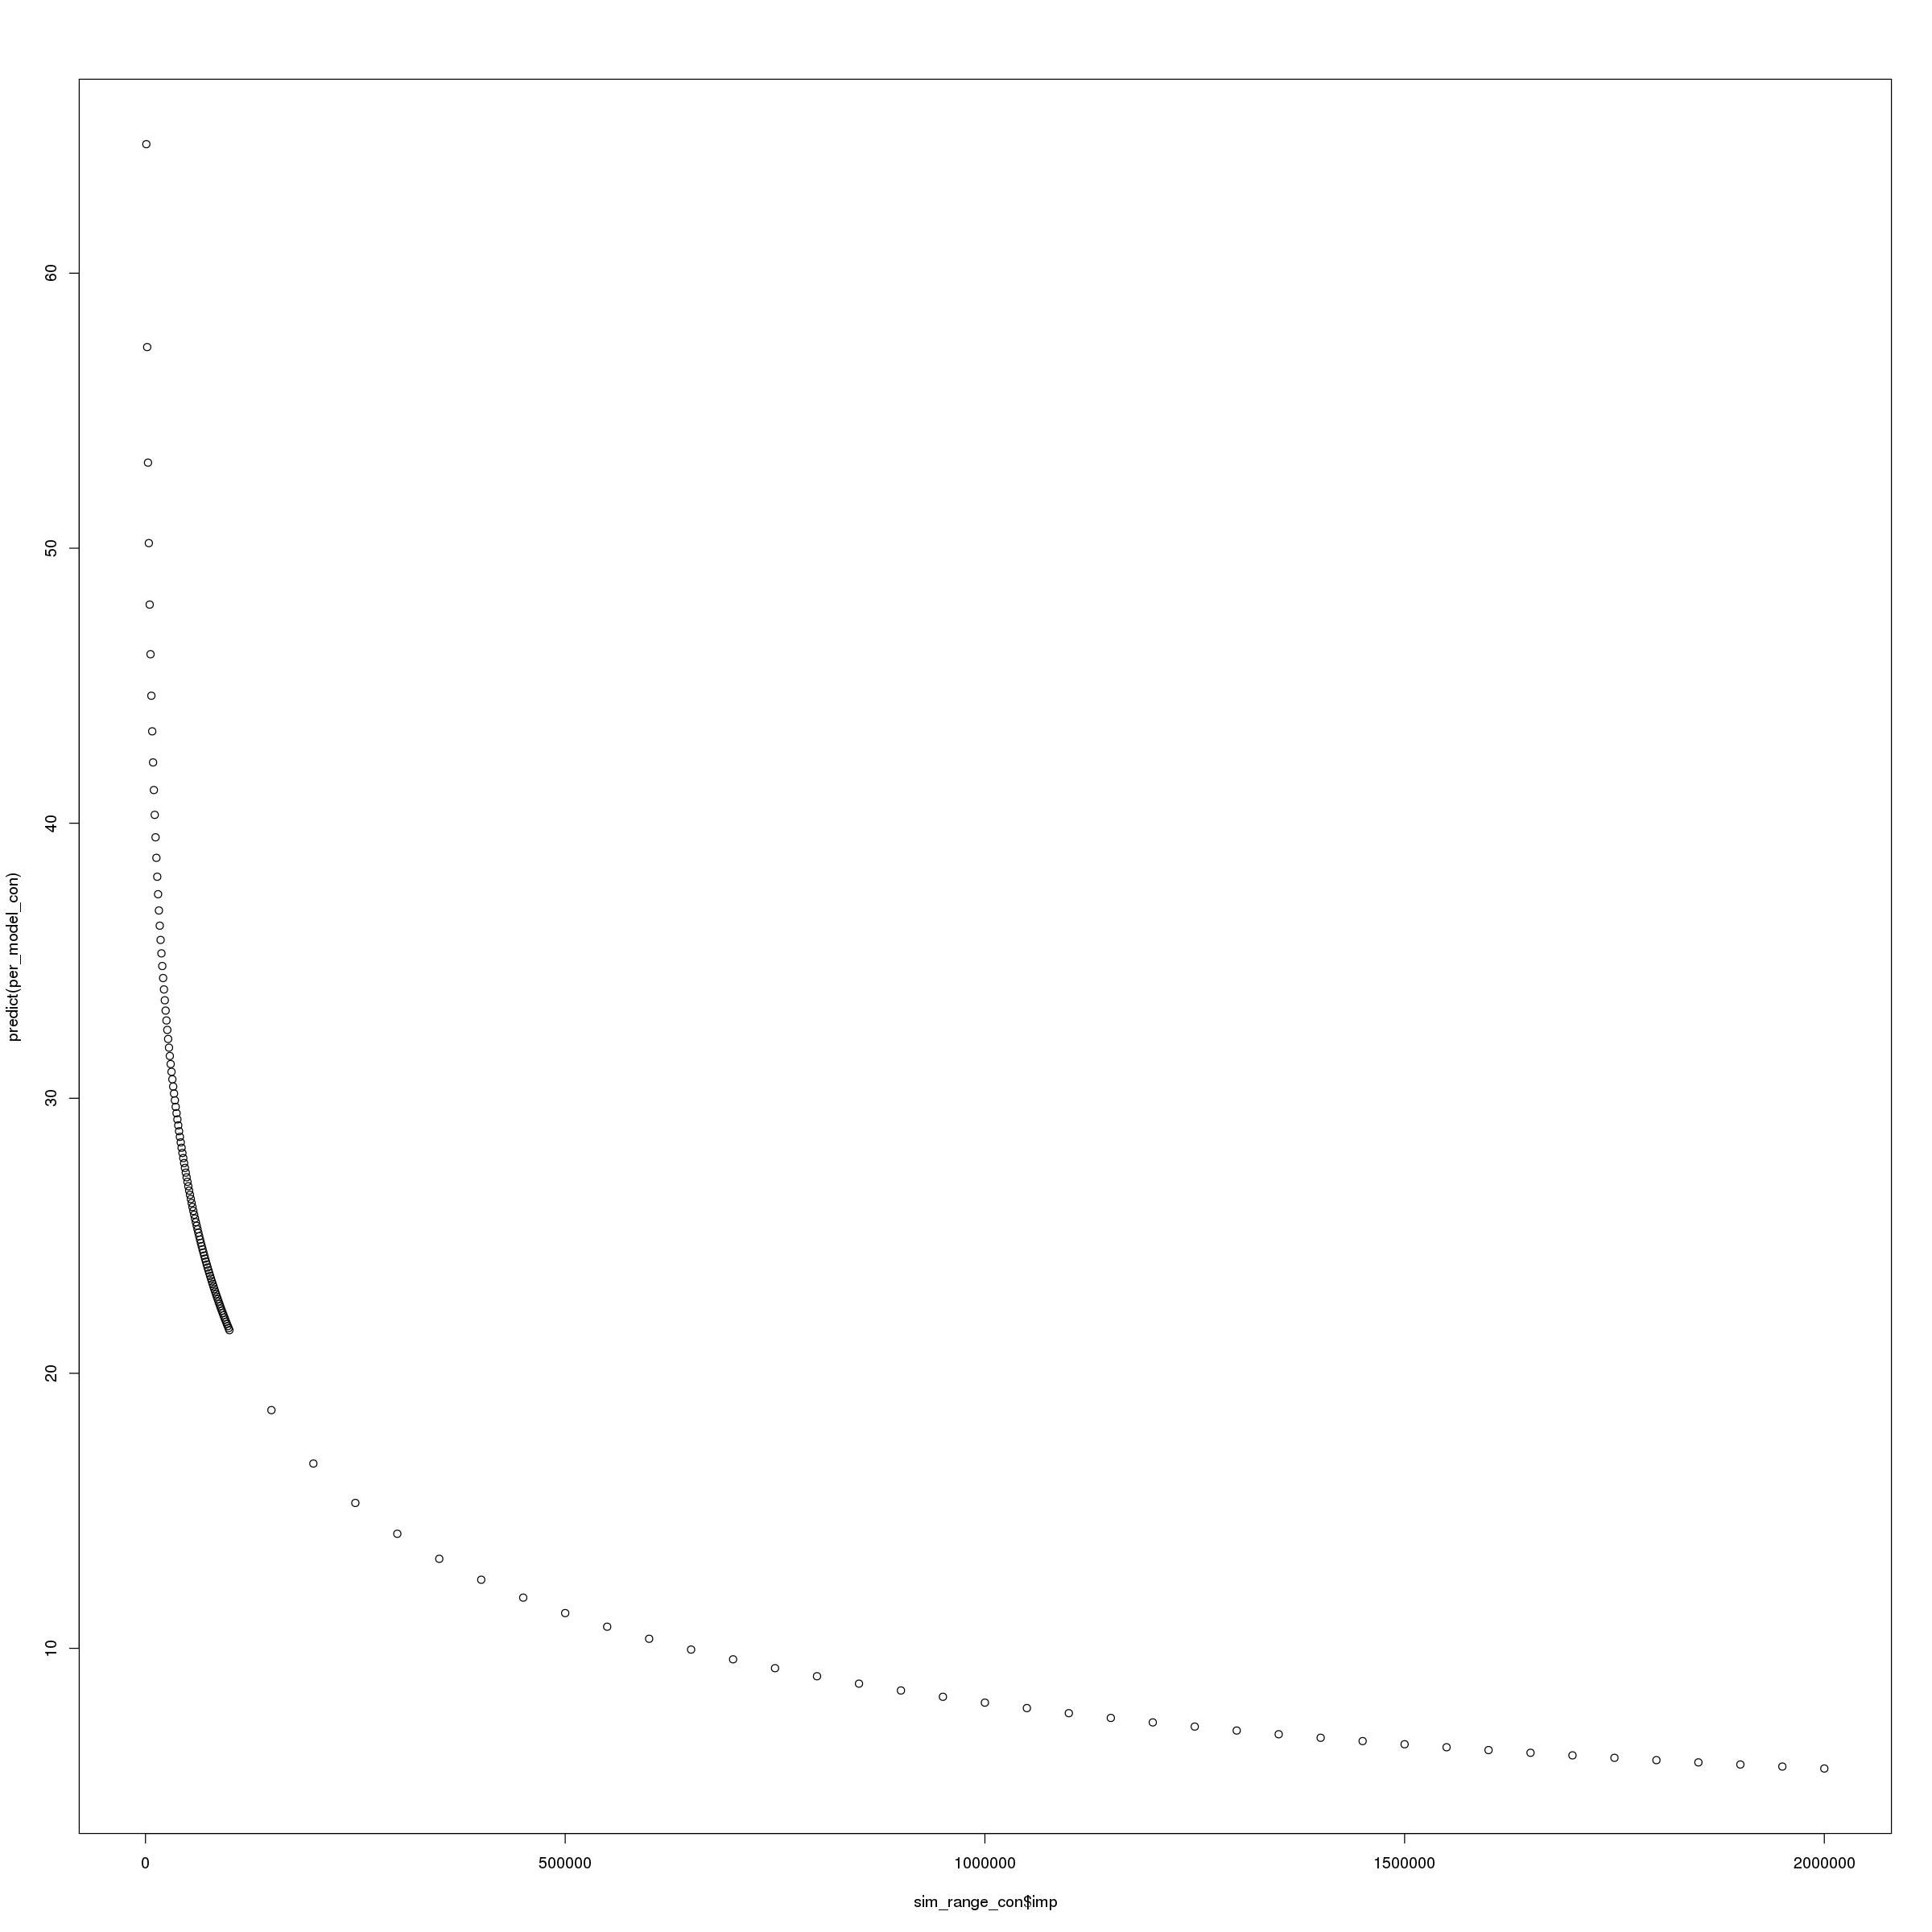

In [43]:
plot(sim_range_con$std_score, predict(per_model_con))
plot(sim_range_con$imp, predict(per_model_con))

In [44]:
per_model_con <- lm(formula = std_score ~ I(log(imp)) + I(imp ^ 0.2), data = sim_range_con, weight = imp)

In [45]:
summary(per_model_con)


Call:
lm(formula = std_score ~ I(log(imp)) + I(imp^0.2), data = sim_range_con, 
    weights = imp)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-582.10  -68.58   52.47   82.23  110.55 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 143.62228    1.44695   99.26   <2e-16 ***
I(log(imp)) -13.05378    0.18845  -69.27   <2e-16 ***
I(imp^0.2)    2.82335    0.07265   38.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 147.1 on 135 degrees of freedom
Multiple R-squared:  0.9983,	Adjusted R-squared:  0.9983 
F-statistic: 4.01e+04 on 2 and 135 DF,  p-value: < 2.2e-16


In [54]:
imp_tests <- c(seq(1000, 100000, 1000), seq(150000, 2000000, 50000))
mean_vtr <- 0.002778432
std_vtr <- 0.0002587341
sim_range_bad <- data.frame()

In [55]:
for (i in imp_tests) {
    vt_sims <- rbinom(100000, i, mean_vtr - std_vtr)
    res <- data.frame(imp = i, std_rate = sd(vt_sims / i), mean_rate = mean(vt_sims / i), 
                      std_score = sd(pnorm(((vt_sims / i) - mean_vtr) / std_vtr) * 100),
                      mean_score = mean(pnorm(((vt_sims / i) - mean_vtr) / std_vtr) * 100)
                     )
    sim_range_bad <- rbind(sim_range_bad, res)
    }

In [56]:
head(sim_range_bad)

,imp,std_rate,mean_rate,std_score,mean_score
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000,0.0015897607,0.002518060,45.75897,41.90687
2,2000,0.0011229762,0.002514125,43.77883,38.46027
3,3000,0.0009135946,0.002519607,42.13138,37.34559
4,4000,0.0007940411,0.002521668,40.94764,36.44660
5,5000,0.0007079595,0.002521372,39.75046,35.34605
6,6000,0.0006459008,0.002521002,38.76623,34.55336


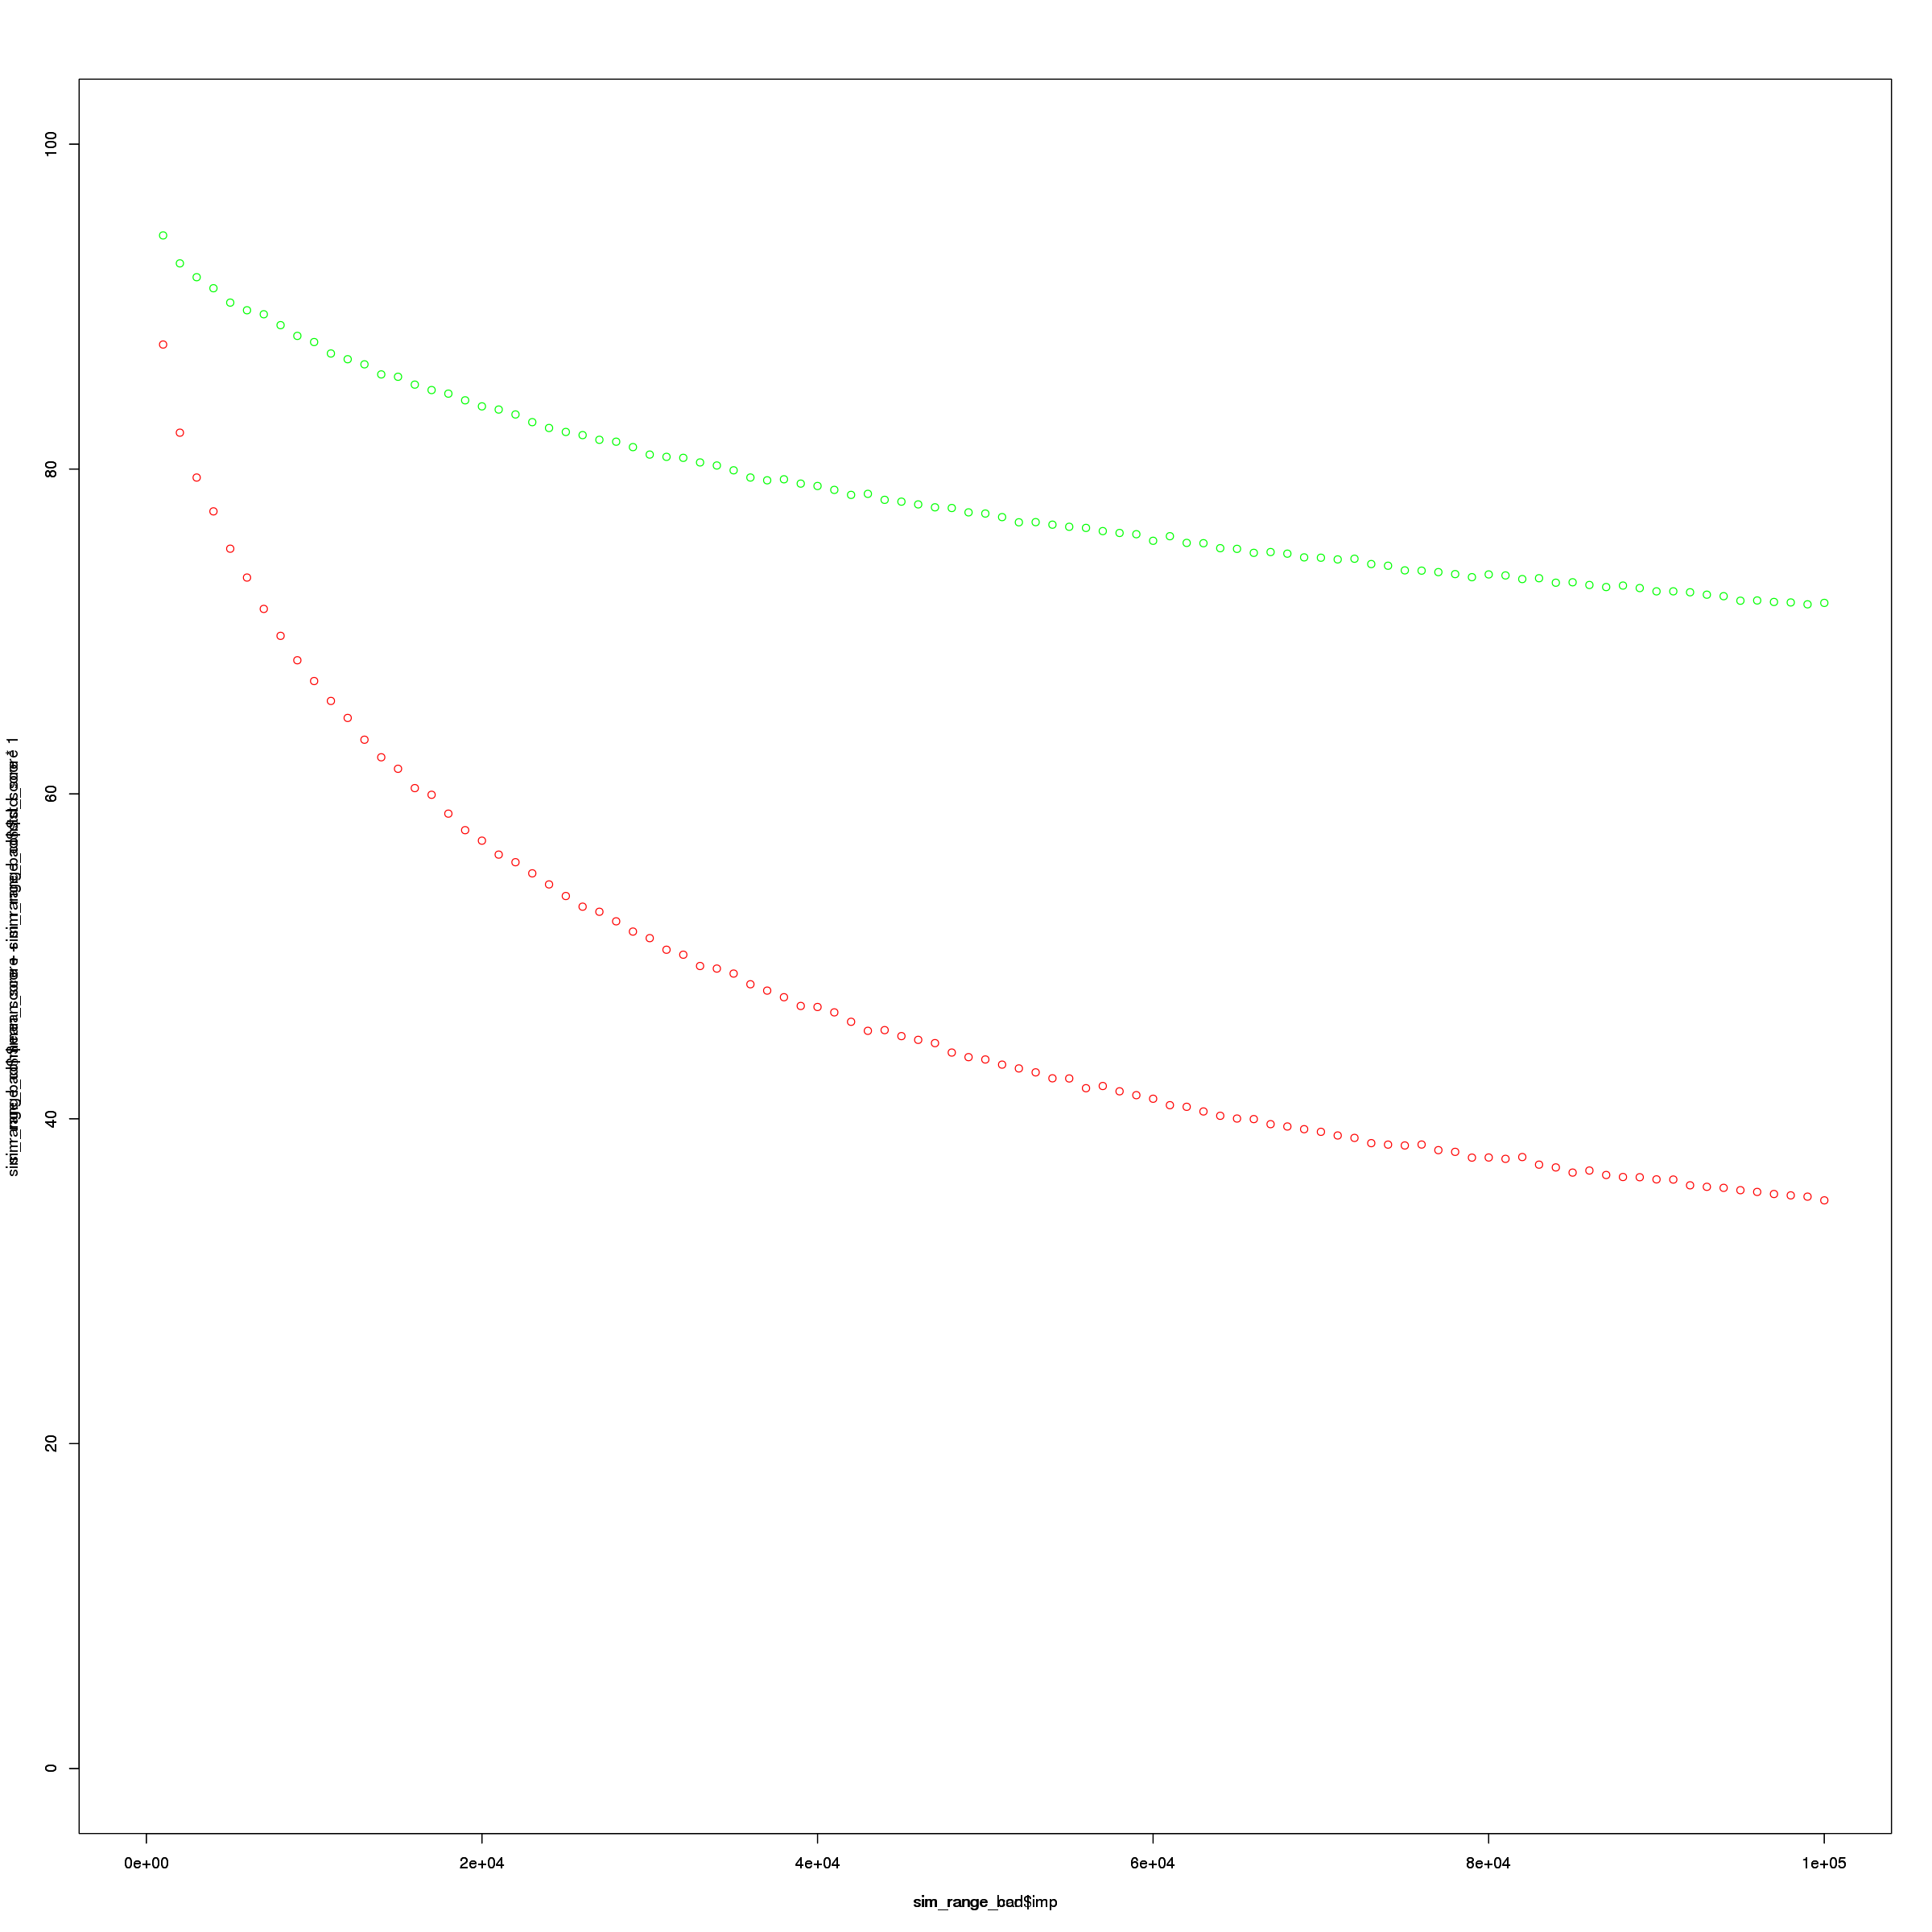

In [69]:
plot(sim_range_con$imp, sim_range_con$mean_score + sim_range_con$std_score, ylim = c(0, 100), col = 'green', xlim=c(0, 100000))
par(new = T)
plot(sim_range_bad$imp, sim_range_bad$mean_score + sim_range_bad$std_score * 1, ylim = c(0, 100), col = 'red', xlim=c(0, 100000))